# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**План работы:**
1. Изучение данных
2. Предобработка данных (поиск пропущенных данных, аномалий, дупбликатов и тд)
3. Добавление новых столбцов для упрощения дальнейшего анализа
4. Исследовательский анализ данных
- анализ параметров и построение графиков (общая площадь; жилая площадь; площадь кухни; цена объекта; количество комнат; высота потолков; этаж квартиры; тип этажа квартиры ; общее количество этажей в доме; расстояние до центра города в метрах; расстояние до ближайшего аэропорта; расстояние до ближайшего парка; день и месяц публикации объявления) 
- от чего зависит скорость продажи
- наиболее значимые факторы, влияющие на цену объекта
- расчет средней цены м2 в 10 населённых пунктах с наибольшим числом объявлений
- расчет средней цены километра по удалению от чентра СпБ
5. Выводы

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd #импортируем библиотеку pandas
import matplotlib.pyplot as plt #импортируем библиотеку matplotlib
from IPython.display import display

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t') #открываем файл

In [3]:
data.info() #изучаем информацию о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
data = data.rename(columns={'cityCenters_nearest' : 'city_centers_nearest'}) #переименовываем столбец в соответствии с правилами змеиного синтаксиса
print(data.columns)

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')


In [5]:
display(data.tail(5)) #смотрим, как выглядят данные

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.7,5.0,73.3,3,NaN,...,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,NaN,...,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,NaN,...,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.0,17.0,NaN,12,NaN,...,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0
23698,4,1350000.0,32.30,2017-07-21T00:00:00,1,2.5,5.0,12.3,1,NaN,...,9.00,NaN,поселок Новый Учхоз,NaN,NaN,NaN,NaN,NaN,NaN,NaN


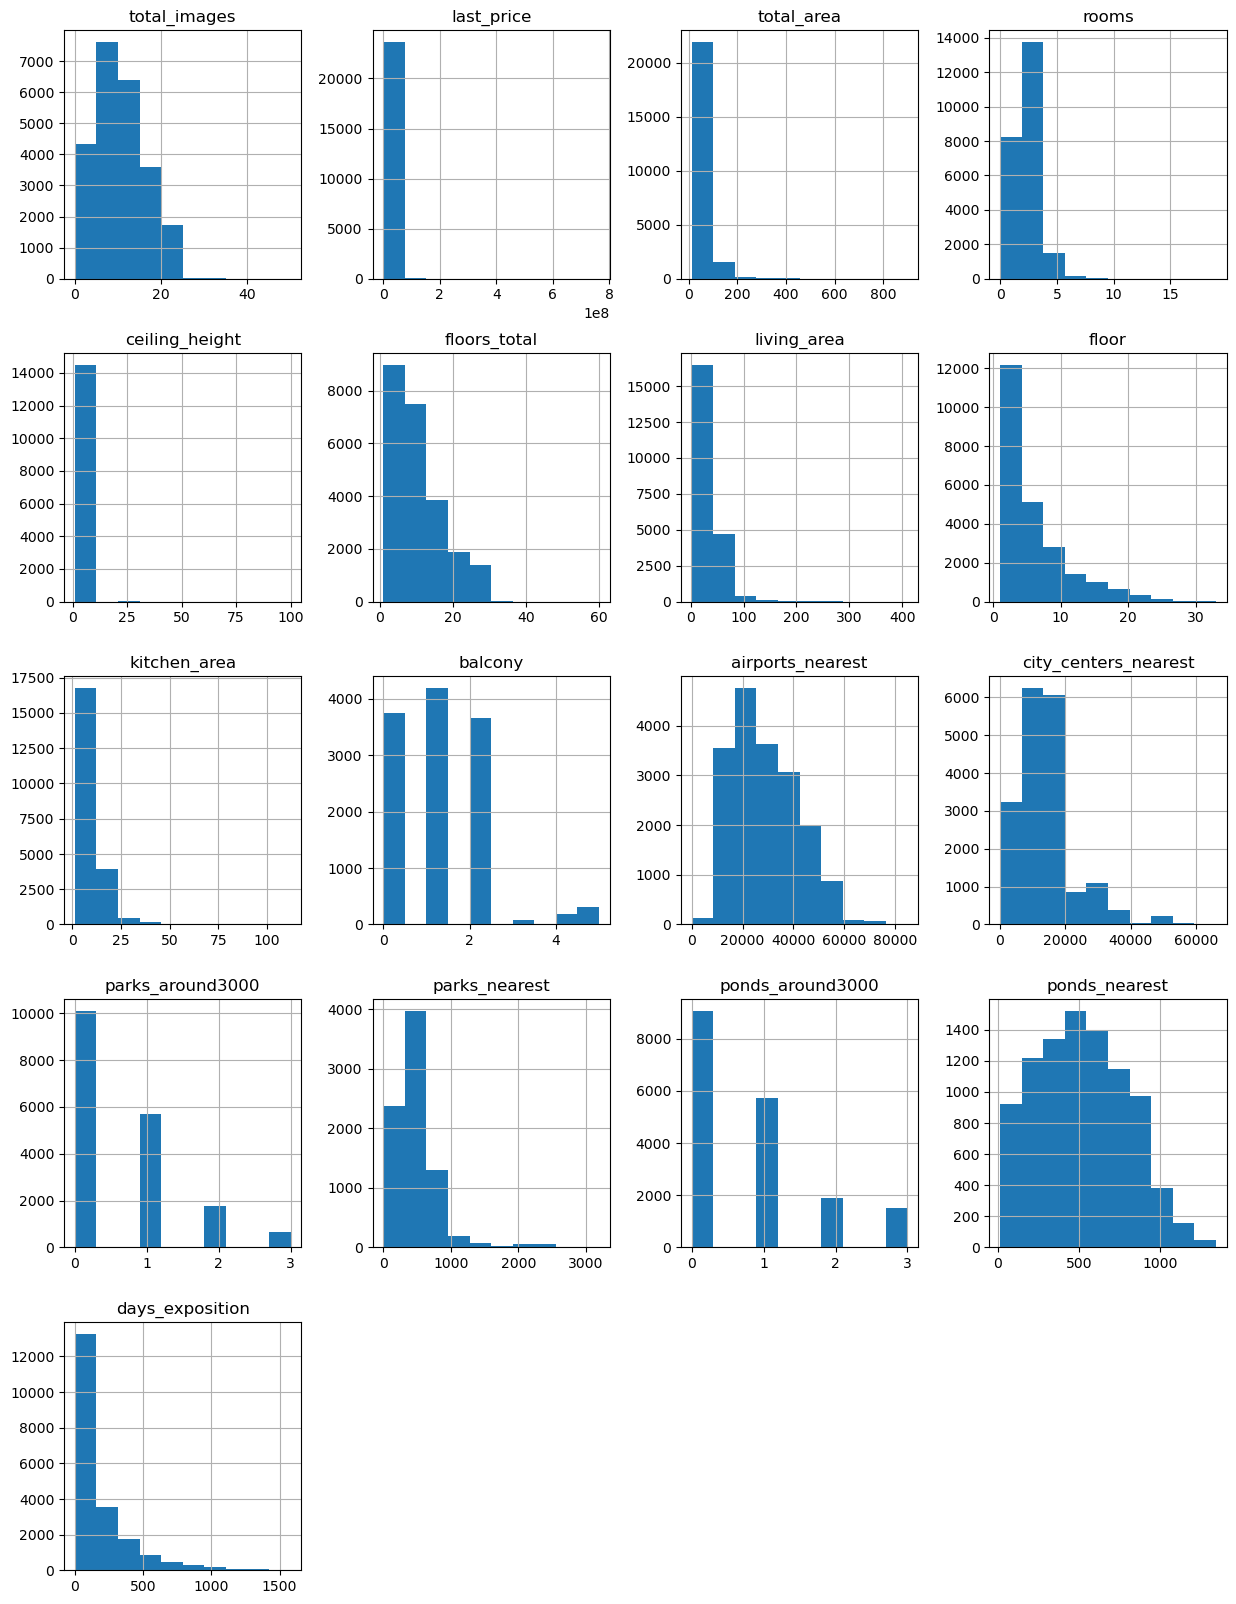

In [6]:
data.hist(figsize=(15, 20)); # строим гистограмму для всех числовых столбцов таблицы

### Предобработка данных

In [7]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = 0, fontsize = 16, grid=True, legend = True)
            .set_title('Доля пропущенных значений в датафрейме по столбцам (%)' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

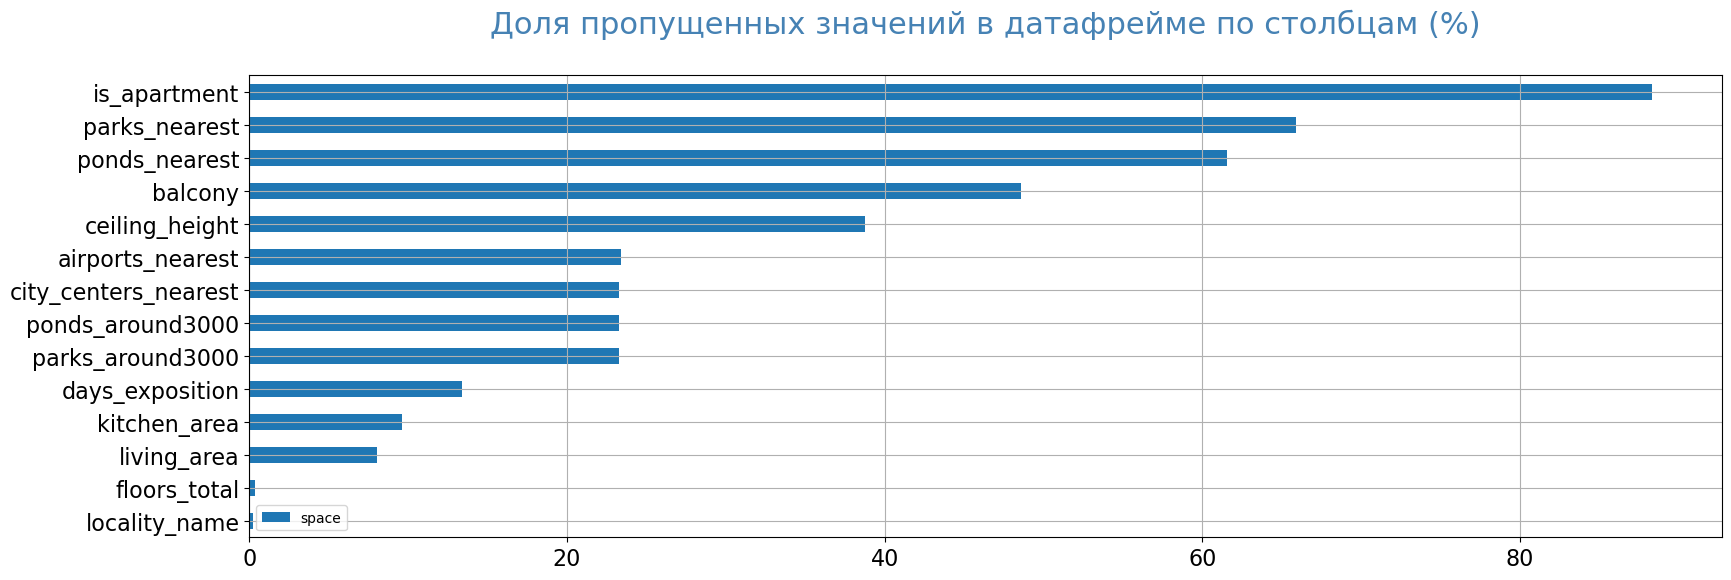

In [8]:
pass_value_barh(data)

#### Пропущенные значения

In [9]:
data.info() #изучаем информацию о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

По результату первичного обращения к данных можно наблюдать наличие пропусков в столбцах ceiling_height, living_area, locality, name, floors_total, is_apartment, kitchen_area, balcony, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest и days_exposition. Необходимо более детальное изучение содержимого данных столбцов.

Заполним пропущенные значения, где это возможно. Например, в случае со столбцом balcony продавец мог не указать число балконов, потому что их нет. Такие значения можно заменить на 0.

In [10]:
data['balcony'] = data['balcony'].fillna(0)
#print(data.head(10))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Можно также предположить, что если значение не указано в столбцах airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, то соответствующих объектов нет поблизости или в указанном диапазоне. В случае с центром города, следует проверить, находится ли объект в городе. Исходя из ТЗ, данные по вышеприведенным столбцам были получены автоматически на основе карт. При необходимости их в дальнейшем анализе следует запросить их у ответственного за получение этих данных сотрудника.

В столбце is_apartment необходимо проверить значения. Предварительный анализ показывает большое количество данных типа NaN. Следует посмотреть уникальные. Можно предположить, что если продавец не указал значение, то это не апартаменты. В таком случае мы можем заменить NaN на False.

In [11]:
print(data['is_apartment'].unique()) #смотрим уникальные значения
data['is_apartment'] = data['is_apartment'].fillna(False) #заменяем отсутствующие значения
print(data['is_apartment'].head(5)) #проверяем результат

[nan False True]
0    False
1    False
2    False
3    False
4    False
Name: is_apartment, dtype: bool


Заполним пропущенные значения в столбце "высота потолков" медианным значением.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

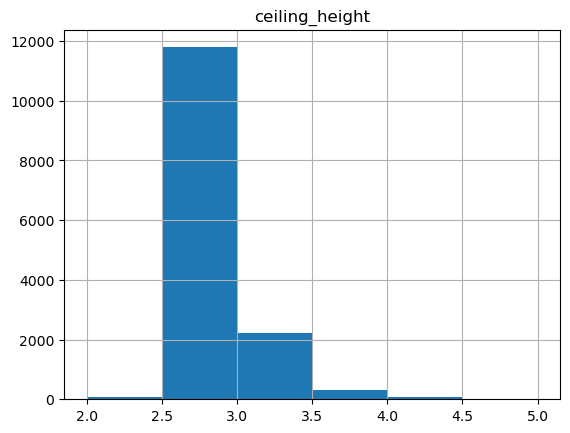

In [12]:
data.hist('ceiling_height', bins=6, range=(2, 5)) # строим график, чтобы посмотреть распределение
data['ceiling_height'].describe() # смотрим основные данные по столбцу, главное- медиана и среднее
median_ceiling_height = data['ceiling_height'].median() # присваиваем новой переменной медианное значение столбца
data['ceiling_height'] = data['ceiling_height'].fillna(median_ceiling_height) #заполняем пропущенные значения в столбце медианным
data.info() # проверяем

В колонке floors_total может отсутствовать значение, если продавец не стал его указвать, так как дом одноэтажный. Заменим в нем пропущенные значения на 1.

In [13]:
data['floors_total'] = data['floors_total'].fillna(1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

#### Типы данных


Неоходимо заменить данные в следующих столбцах: first_day_exposition (это должен быть объект типа датавремя, часы можно отбросить, так как время везде 00:00:00), floors_total (не бывает 1,5 этажа - заменяем на int), is_apartment (это должно быть булевое значение, так как есть только варианты True/False).

In [14]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d') # используем атрибут и метод для изменения офрмата данных
print(data['first_day_exposition']) # проверяем

0       2019-03-07
1       2018-12-04
2       2015-08-20
3       2015-07-24
4       2018-06-19
           ...    
23694   2017-03-21
23695   2018-01-15
23696   2018-02-11
23697   2017-03-28
23698   2017-07-21
Name: first_day_exposition, Length: 23699, dtype: datetime64[ns]


In [15]:
data['floors_total'] = data['floors_total'].astype('int') # используем метод astype для изм типа данных на целые числа (в аргументе)
print(data['floors_total']) # проверяем

0        16
1        11
2         5
3        14
4        14
         ..
23694     5
23695     5
23696     3
23697    17
23698     5
Name: floors_total, Length: 23699, dtype: int32


In [16]:
data['is_apartment'] = data['is_apartment'].astype('bool') # используем метод astype для изм типа данных на булыевае знач (в аргументе)
data.info() # проверяем

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int32         
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

Предположительно, объявления, где не указано место (locality_name), не представляют интереса для покупателей, поэтому их можно удалить. Тем более, что таких строк всего около 50 и более чем 23000.

In [17]:
data = data.dropna(subset=['locality_name']) # удаляем значения методом dropna с параметром subset
data.info() # проверяем

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  float64       
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23650 non-null  int32         
 7   living_area           21752 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          21381 non-null  float64       
 13  balcony         

In [18]:
data['balcony'] = data['balcony'].astype('int') # используем метод astype для изм типа данных на целые числа (в аргументе)
print(data['balcony']) # проверяем

0        0
1        2
2        0
3        0
4        0
        ..
23694    0
23695    0
23696    0
23697    2
23698    0
Name: balcony, Length: 23650, dtype: int32


#### Уникальные значения в столбце с названиями

Проверим уникальные значения в столбце с названиями населенных пунктов и заменим дубликаты.

In [19]:
#print(data['locality_name'].unique()) # смотрим уникальные значения
data['locality_name'] = (data['locality_name'].str.replace('ё','е')) # используем метод str.replace для замены ё на е
data['locality_name'] = data['locality_name'].str.lower() # используем метод str.lower для приведения данных у нижнему регистру
print(data['locality_name'].unique()) # проверяем и находим неявные дубликаты, которые заменяем вручную
data['locality_name'] = data['locality_name'].replace('городской поселок мга', 'поселок городского типа мга')
data['locality_name'] = data['locality_name'].replace('поселок городского типа рябово', 'поселок рябово')
data['locality_name'] = data['locality_name'].replace('поселок городского типа рахья', 'садовое товарищество рахья')
data.info() # проверяем

['санкт-петербург' 'поселок шушары' 'городской поселок янино-1'
 'поселок парголово' 'поселок мурино' 'ломоносов' 'сертолово' 'петергоф'
 'пушкин' 'деревня кудрово' 'коммунар' 'колпино'
 'поселок городского типа красный бор' 'гатчина' 'деревня федоровское'
 'выборг' 'кронштадт' 'кировск' 'деревня новое девяткино'
 'поселок металлострой' 'поселок городского типа лебяжье'
 'поселок городского типа сиверский' 'поселок молодцово'
 'поселок городского типа кузьмоловский'
 'садовое товарищество новая ропша' 'павловск' 'деревня пикколово'
 'всеволожск' 'волхов' 'кингисепп' 'приозерск' 'сестрорецк'
 'деревня куттузи' 'поселок аннино' 'поселок городского типа ефимовский'
 'поселок плодовое' 'деревня заклинье' 'поселок торковичи'
 'поселок первомайское' 'красное село' 'поселок понтонный' 'сясьстрой'
 'деревня старая' 'деревня лесколово' 'поселок новый свет' 'сланцы'
 'село путилово' 'ивангород' 'мурино' 'шлиссельбург' 'никольское'
 'зеленогорск' 'сосновый бор' 'деревня оржицы' 'деревня кальтино'

In [20]:
# check
data.locality_name.nunique()

327

In [21]:
data.duplicated(['total_area', 'floor', 'floors_total', 'city_centers_nearest', 'locality_name', 'rooms']).sum()

208

#### Редкие и выбивающиеся значения

Найдем и исправим или удалим аномалии в столбце с высотой потолков. Для начала заменим значения, которые, вероятно, являются результатом описки. Затем удалим нереалистичные значения. Предположительно, могут быть апартаменты с высотой потолков от 2 до 5 метров, поэтому оставим значения в этом диапазоне.

In [22]:
#print(data['ceiling_height'].unique()) # находим уникальные значения в нужном столбце
data['ceiling_height'] = data['ceiling_height'].replace(26.0, 2.6) #заменяем ошибочные знаения на правдоподобные
data['ceiling_height'] = data['ceiling_height'].replace(22.6, 2.26)
data['ceiling_height'] = data['ceiling_height'].replace(27.0, 2.7)
data['ceiling_height'] = data['ceiling_height'].replace(32.0, 3.2)
data['ceiling_height'] = data['ceiling_height'].replace(27.5, 2.75)
data['ceiling_height'] = data['ceiling_height'].replace(24.0, 2.4)
data['ceiling_height'] = data['ceiling_height'].replace(20.0, 2.0)
data['ceiling_height'] = data['ceiling_height'].replace(25.0, 2.5)
data['ceiling_height'] = data['ceiling_height'].replace(100.0, 10.0)
data = data[~data['ceiling_height'].isin([1.0, 1.2, 1.75, 14, 10.0, 10.3, 8.3, 6.0, 8.0, 5.8, 5.2, 5.3, 5.6, 5.5])] #удаляем неправдоподобные значения


In [23]:
data = data.loc[((data['ceiling_height'] >= 2.3) & (data['ceiling_height'] <= 5))] # удаляем значения менее 2,3м и более 5м.
data = data.reset_index(drop=True) # обновляем индексы
data.info() # проверяем, удалились ли данные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23618 entries, 0 to 23617
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23618 non-null  int64         
 1   last_price            23618 non-null  float64       
 2   total_area            23618 non-null  float64       
 3   first_day_exposition  23618 non-null  datetime64[ns]
 4   rooms                 23618 non-null  int64         
 5   ceiling_height        23618 non-null  float64       
 6   floors_total          23618 non-null  int32         
 7   living_area           21724 non-null  float64       
 8   floor                 23618 non-null  int64         
 9   is_apartment          23618 non-null  bool          
 10  studio                23618 non-null  bool          
 11  open_plan             23618 non-null  bool          
 12  kitchen_area          21356 non-null  float64       
 13  balcony         

####  Аномалии в других столбцах

'rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area', 'floors_total'

In [24]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,618.00","23,618.00","23,618.00","20,444.00","23,618.00","21,724.00","21,356.00","23,618.00","23,618.00"
min,0.00,12.00,2.30,1.00,"12,190.00",2.00,1.30,1.00,1.00
max,19.00,900.00,5.00,"1,580.00","763,000,000.00",409.70,112.00,33.00,60.00


In [25]:
#data.query('rooms == 0')
data['rooms'] = data['rooms'].replace(0, 1) #квартир без комнат не бывает, предположим, что там одна комната и заменим значения
data.query('rooms == 0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


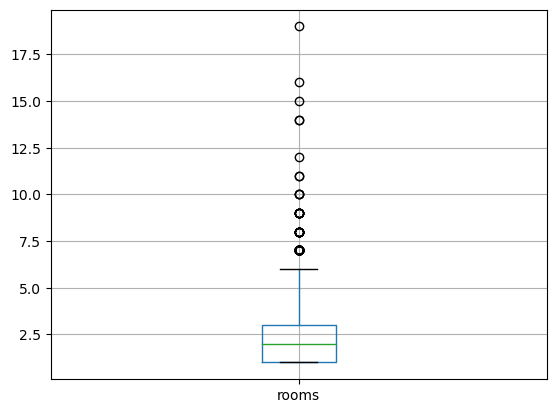

In [26]:
data.boxplot('rooms')
data.query('rooms > 6')
data.rooms.value_counts().to_frame()
wrong_values = [7, 8, 9, 10, 11, 14, 16, 19, 12, 15]
data = data[data['rooms'].isin(wrong_values) == False]

In [27]:
print(data['rooms'].unique())

[3 1 2 4 5 6]


Пропусков нет. Выбросами можно считать более 6 комнат. Таких значений всего 90, на выборку не повлияют. Можно удалить.

[317.   310.   323.   290.6  280.   274.65 304.   255.   266.2  441.98
 281.1  290.   380.   283.   500.   363.1  470.3  256.   488.   307.8
 251.   315.   312.   507.   300.   259.2  268.   263.8  260.   494.1
 295.   253.7  320.   284.   259.6  288.   274.   410.   402.   327.2
 250.3  401.   293.6  250.2  336.   285.7  301.9  371.   365.   283.3
 460.8  267.7  254.   342.   422.2  491.   275.   297.5 ]


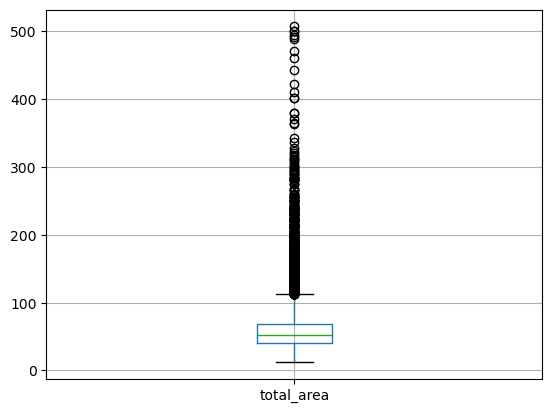

In [28]:
data.boxplot('total_area')
data['total_area'].describe()
#data.query('total_area > 250')
total_area = data.loc[data.loc[:, 'total_area'] > 250]['total_area']
print(total_area.unique())
data = data[~data['total_area'].isin([317., 310., 323., 290.6, 280., 274.65, 304., 255., 266.2, 441.98,
 281.1, 290., 380., 283., 500., 363.1, 470.3, 256., 488., 307.8,
 251., 315., 312., 507., 300., 259.2, 268., 263.8, 260., 494.1,
 295., 253.7, 320., 284., 259.6, 288., 274., 410., 402., 327.2,
 250.3, 401., 293.6, 250.2, 336., 285.7, 301.9, 371., 365., 283.3,
 460.8, 267.7, 254., 342., 422.2, 491., 275., 297.5])]

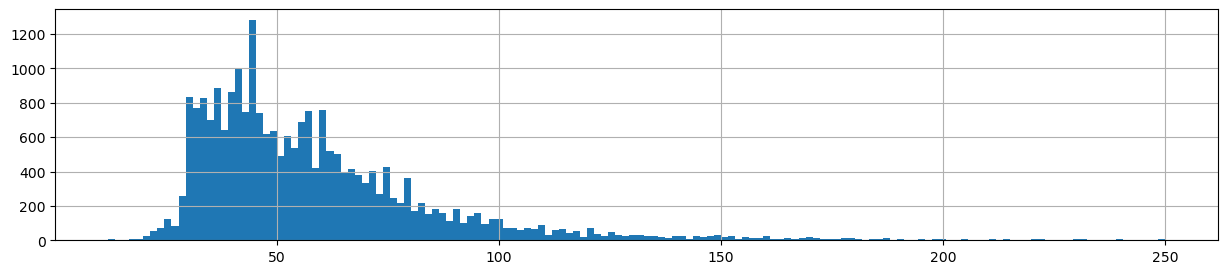

In [29]:
data.total_area.hist(bins = 150, figsize = (15,3));

Здесь выбросы начинаются примерно на отметке в 100м2. Но квартир более 100м2 - более 1825. Это слишком много, и удаление такого количества объявлений может повлиять на дальнейшие расчеты.
Кроме того, большие и дорогие квартиры могут составлять отдельный сегмент. Так же, как и крошечные дешевые.
*графики позже увидела*

In [30]:
total_area = data.loc[data.loc[:, 'total_area'] < 20]['total_area']
print(total_area.unique())
data = data[~data['total_area'].isin([17., 18., 19.5, 19., 18.4, 18.8, 15.5, 17.6, 16., 15., 18.5, 13.,
 13.2, 14., 12., 17.78, 17.2, 18.9])]

[17.   18.   19.5  19.   18.4  18.8  15.5  17.6  16.   15.   18.5  13.
 13.2  14.   12.   17.78 17.2  18.9 ]


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23430 entries, 0 to 23617
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23430 non-null  int64         
 1   last_price            23430 non-null  float64       
 2   total_area            23430 non-null  float64       
 3   first_day_exposition  23430 non-null  datetime64[ns]
 4   rooms                 23430 non-null  int64         
 5   ceiling_height        23430 non-null  float64       
 6   floors_total          23430 non-null  int32         
 7   living_area           21565 non-null  float64       
 8   floor                 23430 non-null  int64         
 9   is_apartment          23430 non-null  bool          
 10  studio                23430 non-null  bool          
 11  open_plan             23430 non-null  bool          
 12  kitchen_area          21213 non-null  float64       
 13  balcony         

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
154,1,8200000.0,80.00,2018-11-06,3,4.15,3,44.2,2,False,...,12.20,0,санкт-петербург,20562.0,3167.0,2.0,344.0,1.0,838.0,38.0
179,5,14800000.0,108.70,2019-04-11,3,4.00,5,72.4,5,False,...,8.00,0,санкт-петербург,23017.0,2559.0,1.0,559.0,0.0,NaN,NaN
368,19,12500000.0,85.00,2018-09-21,3,3.70,6,56.5,6,False,...,22.00,0,санкт-петербург,27084.0,5777.0,2.0,516.0,1.0,36.0,4.0
795,1,7500800.0,105.20,2017-09-08,3,3.80,5,62.6,2,False,...,19.20,0,санкт-петербург,24705.0,4924.0,2.0,521.0,0.0,NaN,79.0
883,9,8200000.0,96.00,2018-07-23,3,3.62,3,61.6,3,False,...,8.50,0,кронштадт,69690.0,51415.0,3.0,87.0,3.0,412.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22885,19,35000000.0,236.00,2019-03-26,6,4.00,5,164.3,2,False,...,16.40,1,санкт-петербург,31670.0,8748.0,1.0,243.0,1.0,827.0,18.0
22934,8,2250000.0,28.30,2017-08-04,1,3.70,3,10.9,2,False,...,7.30,0,ломоносов,49713.0,53138.0,2.0,170.0,3.0,110.0,424.0
23249,6,19900000.0,144.00,2017-01-09,3,3.80,5,79.5,3,False,...,20.00,0,санкт-петербург,24705.0,4924.0,2.0,521.0,0.0,NaN,NaN
23301,2,15000000.0,150.90,2016-07-04,4,3.67,4,98.2,3,False,...,23.90,0,санкт-петербург,21204.0,2180.0,3.0,105.0,1.0,614.0,455.0


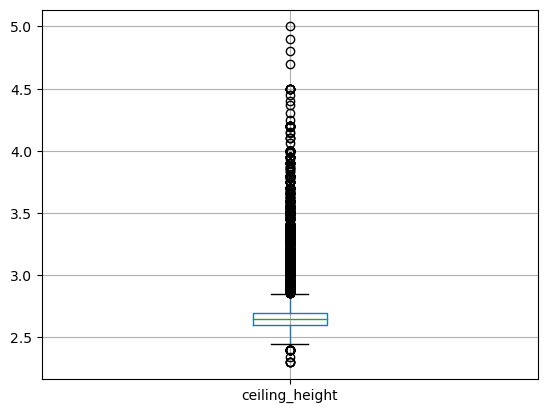

In [32]:
data.boxplot('ceiling_height')
data['ceiling_height'].describe()
data.query('ceiling_height > 3.6')

Здесь опять же график показывает, что примерно с 2,8 - выбросы, хотя таких значений более 3000. Кроме того, в Питере есть сталинсике дома, где потолки около 3,5м.

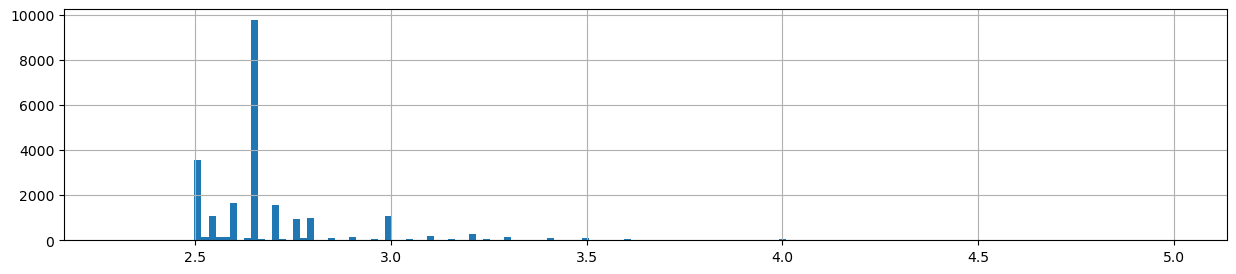

In [33]:
data.ceiling_height.hist(bins = 150, figsize = (15,3));

In [34]:
ceiling_height = data.loc[data.loc[:, 'ceiling_height'] > 3.6]['ceiling_height']
print(ceiling_height.unique())
data = data[~data['ceiling_height'].isin([4.15, 4., 3.7, 3.8, 3.62, 5., 4.06, 3.65, 3.98, 3.83, 3.95, 3.75, 3.67, 3.87,
 3.66, 3.85, 4.19, 4.8, 4.5, 4.2, 3.86, 3.68, 4.37, 3.9,  4.1,  3.63, 4.45, 3.84,
 3.78, 4.3, 4.4, 3.93, 4.14, 3.88, 4.25, 3.76, 3.69, 4.7, 4.9])]

[4.15 4.   3.7  3.8  3.62 5.   4.06 3.65 3.98 3.83 3.95 3.75 3.67 3.87
 3.66 3.85 4.19 4.8  4.5  4.2  3.86 3.68 4.37 3.9  4.1  3.63 4.45 3.84
 3.78 4.3  4.4  3.93 4.14 3.88 4.25 3.76 3.69 4.7  4.9 ]


In [35]:
ceiling_height = data.loc[data.loc[:, 'ceiling_height'] < 2.5]['ceiling_height']
print(ceiling_height.unique())
data = data[~data['ceiling_height'].isin([2.47, 2.34, 2.45, 2.46, 2.4, 2.3, 2.48, 2.49])]

[2.47 2.34 2.45 2.46 2.4  2.3  2.48 2.49]


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23203 entries, 0 to 23617
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23203 non-null  int64         
 1   last_price            23203 non-null  float64       
 2   total_area            23203 non-null  float64       
 3   first_day_exposition  23203 non-null  datetime64[ns]
 4   rooms                 23203 non-null  int64         
 5   ceiling_height        23203 non-null  float64       
 6   floors_total          23203 non-null  int32         
 7   living_area           21351 non-null  float64       
 8   floor                 23203 non-null  int64         
 9   is_apartment          23203 non-null  bool          
 10  studio                23203 non-null  bool          
 11  open_plan             23203 non-null  bool          
 12  kitchen_area          20998 non-null  float64       
 13  balcony         

<AxesSubplot:>

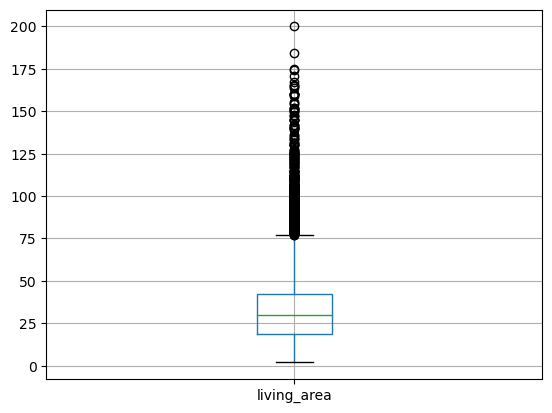

In [37]:
data.boxplot('living_area')

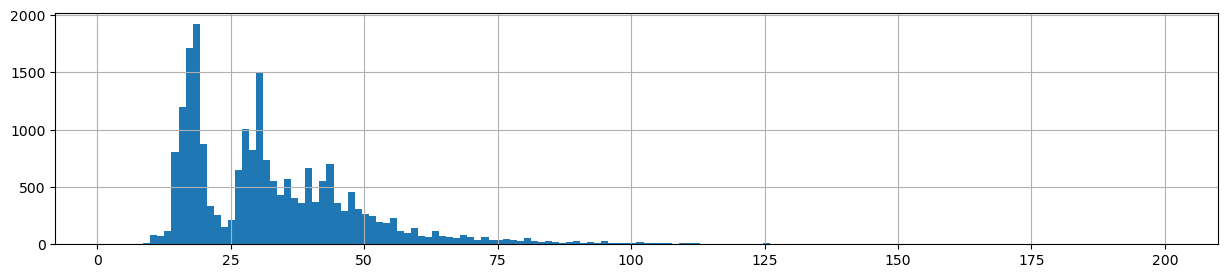

In [38]:
data.living_area.hist(bins = 150, figsize = (15,3));

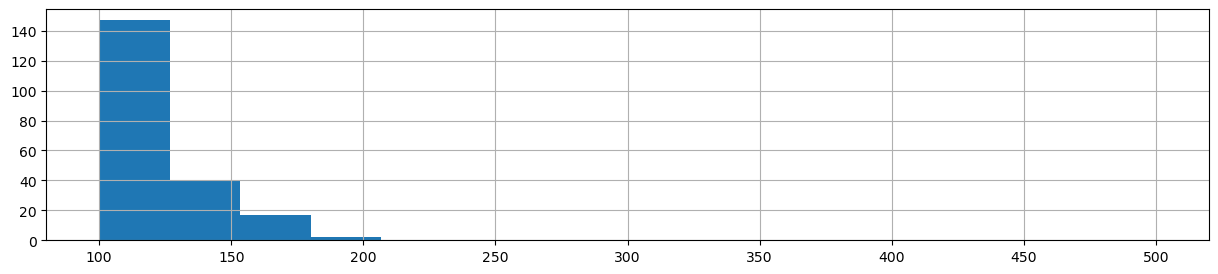

In [39]:
data.living_area.hist(bins = 15, figsize = (15,3), range = (100,500));

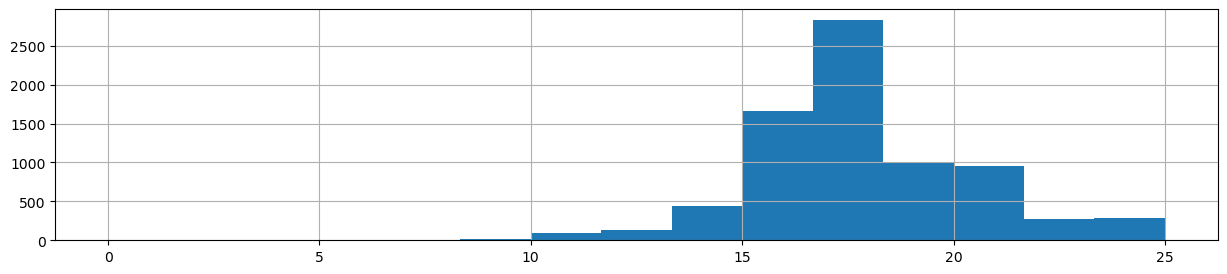

In [40]:
data.living_area.hist(bins = 15, figsize = (15,3), range = (0, 25));

In [41]:
data.query('living_area < 10')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
114,5,4000000.0,21.40,2019-02-07,1,2.90,8,8.3,7,False,...,6.3,0,санкт-петербург,27089.0,5791.0,2.0,488.0,1.0,286.0,NaN
678,14,7200000.0,43.00,2017-10-31,1,2.65,8,9.0,2,False,...,23.0,0,санкт-петербург,23900.0,5232.0,1.0,2137.0,1.0,933.0,296.0
1322,8,8100000.0,52.00,2017-01-29,2,2.70,25,9.0,15,False,...,32.0,2,санкт-петербург,35555.0,15561.0,0.0,NaN,1.0,1180.0,337.0
2303,10,4200000.0,62.40,2017-06-15,2,2.60,9,8.4,6,False,...,41.0,2,поселок шушары,23662.0,29448.0,0.0,NaN,0.0,NaN,111.0
3233,7,4440000.0,41.00,2017-07-02,1,2.65,17,3.0,17,False,...,11.0,0,санкт-петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0
4089,17,5300000.0,34.80,2017-06-19,1,2.70,23,9.0,15,False,...,17.1,0,санкт-петербург,33626.0,13495.0,0.0,NaN,0.0,NaN,30.0
7290,8,3400000.0,27.00,2018-02-21,2,2.50,15,9.0,4,False,...,16.0,0,санкт-петербург,50246.0,16444.0,1.0,617.0,0.0,NaN,NaN
8300,9,4800000.0,52.00,2017-10-25,2,2.65,5,9.0,2,False,...,6.0,1,санкт-петербург,33358.0,13171.0,0.0,NaN,2.0,118.0,119.0
13878,20,6350000.0,52.00,2018-02-06,2,3.00,6,2.0,2,False,...,9.0,0,санкт-петербург,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0
15791,20,4600000.0,33.00,2017-01-01,1,2.70,22,9.0,12,False,...,14.3,1,санкт-петербург,33803.0,13671.0,0.0,NaN,0.0,NaN,511.0


In [42]:
living_area = data.loc[data.loc[:, 'living_area'] < 10]['living_area']
print(living_area.unique())
data = data[~data['living_area'].isin([8.3, 9., 8.4, 3., 2., 6., 8.9, 5., 6.5, 8., 8.5, 9.8, 5.4, 9.1])]

[8.3 9.  8.4 3.  2.  6.  8.9 5.  6.5 8.  8.5 9.8 5.4 9.1]


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23179 entries, 0 to 23617
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23179 non-null  int64         
 1   last_price            23179 non-null  float64       
 2   total_area            23179 non-null  float64       
 3   first_day_exposition  23179 non-null  datetime64[ns]
 4   rooms                 23179 non-null  int64         
 5   ceiling_height        23179 non-null  float64       
 6   floors_total          23179 non-null  int32         
 7   living_area           21327 non-null  float64       
 8   floor                 23179 non-null  int64         
 9   is_apartment          23179 non-null  bool          
 10  studio                23179 non-null  bool          
 11  open_plan             23179 non-null  bool          
 12  kitchen_area          20976 non-null  float64       
 13  balcony         

<AxesSubplot:>

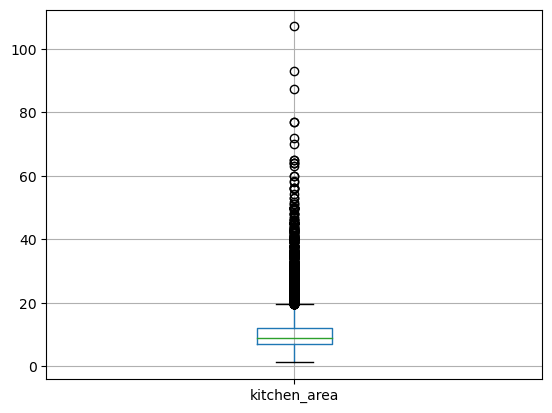

In [44]:
data.boxplot('kitchen_area')

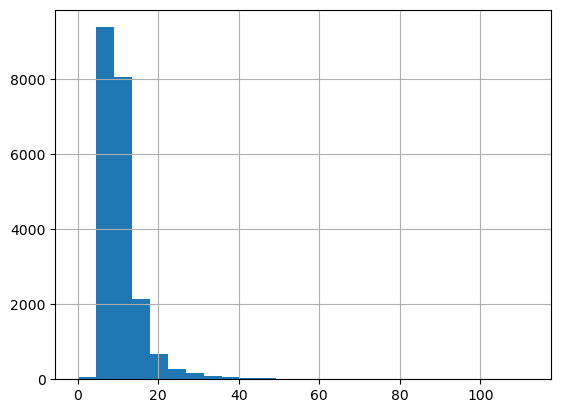

In [45]:
data['kitchen_area'].hist(bins=25, range=(0,112));

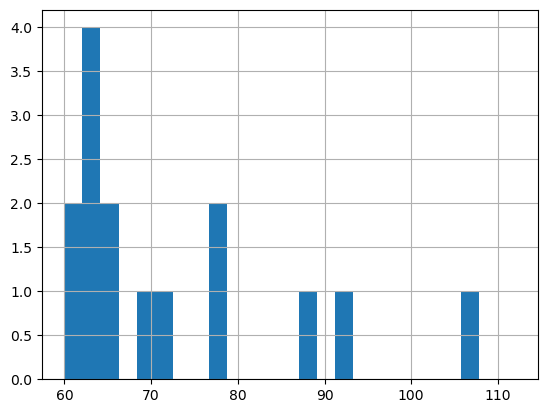

In [46]:
data['kitchen_area'].hist(bins=25, range=(60,112));

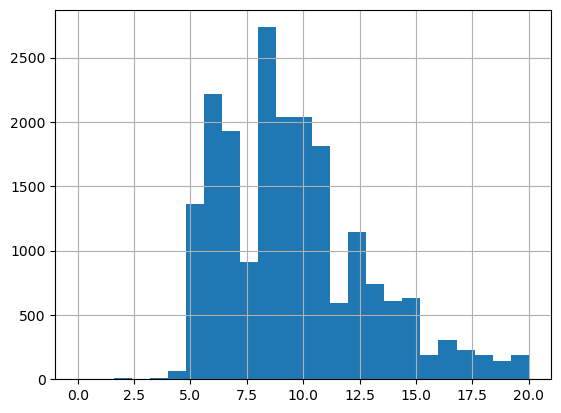

In [47]:
data['kitchen_area'].hist(bins=25, range=(0,20));

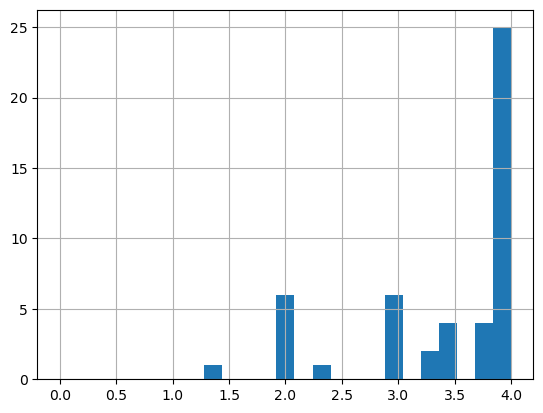

In [48]:
data['kitchen_area'].hist(bins=25, range=(0,4));

In [49]:
data.query('kitchen_area > 60')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
491,18,95000000.0,216.0,2017-12-05,4,3.00,5,86.0,4,False,...,77.0,0,санкт-петербург,21740.0,436.0,2.0,138.0,3.0,620.0,14.0
4380,20,57000000.0,174.0,2015-11-09,3,3.20,10,95.0,6,False,...,77.0,0,санкт-петербург,31706.0,4166.0,1.0,193.0,3.0,199.0,1039.0
6173,19,24300000.0,230.0,2016-06-03,4,2.65,3,90.0,2,False,...,70.0,0,санкт-петербург,39422.0,15354.0,0.0,NaN,1.0,345.0,397.0
10838,1,56844500.0,177.9,2015-01-15,3,2.65,6,87.2,5,True,...,87.2,0,санкт-петербург,21860.0,318.0,2.0,160.0,3.0,569.0,NaN
15738,9,12990000.0,119.6,2017-03-13,3,3.00,5,36.4,4,False,...,64.0,4,пушкин,18616.0,30770.0,1.0,569.0,0.0,NaN,NaN
16600,15,122000000.0,145.0,2017-04-25,3,3.30,6,36.0,2,False,...,72.0,0,санкт-петербург,33931.0,7023.0,2.0,478.0,3.0,250.0,335.0
16750,9,65850000.0,146.0,2017-07-14,2,2.65,9,40.0,3,False,...,93.0,0,санкт-петербург,25525.0,5845.0,2.0,116.0,0.0,NaN,77.0
17858,17,135000000.0,166.0,2019-02-07,3,3.30,7,52.0,1,False,...,64.0,0,санкт-петербург,32863.0,5955.0,2.0,230.0,3.0,215.0,NaN
18393,17,21800000.0,187.0,2018-01-14,5,2.65,4,120.0,4,False,...,65.0,0,санкт-петербург,43758.0,15461.0,1.0,756.0,2.0,278.0,NaN
19072,11,40000000.0,153.0,2017-09-02,3,3.30,10,45.2,7,False,...,63.0,2,санкт-петербург,NaN,NaN,NaN,NaN,NaN,NaN,455.0


In [50]:
kitchen_area = data.loc[data.loc[:, 'kitchen_area'] > 60]['kitchen_area']
print(kitchen_area.unique())
data = data[~data['kitchen_area'].isin([77., 70.,  87.2, 72., 93., 64., 65., 63., 107.])]

[ 77.   70.   87.2  64.   72.   93.   65.   63.  107. ]


In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23166 entries, 0 to 23617
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23166 non-null  int64         
 1   last_price            23166 non-null  float64       
 2   total_area            23166 non-null  float64       
 3   first_day_exposition  23166 non-null  datetime64[ns]
 4   rooms                 23166 non-null  int64         
 5   ceiling_height        23166 non-null  float64       
 6   floors_total          23166 non-null  int32         
 7   living_area           21314 non-null  float64       
 8   floor                 23166 non-null  int64         
 9   is_apartment          23166 non-null  bool          
 10  studio                23166 non-null  bool          
 11  open_plan             23166 non-null  bool          
 12  kitchen_area          20963 non-null  float64       
 13  balcony         

In [52]:
data.query('kitchen_area < 4')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
904,15,2600000.0,27.00,2017-07-10,1,2.75,23,18.0,18,False,...,2.00,0,санкт-петербург,22131.0,17459.0,0.0,NaN,1.0,411.0,10.0
2159,15,3180000.0,25.00,2019-03-21,1,2.50,25,17.0,17,False,...,3.00,0,поселок мурино,NaN,NaN,NaN,NaN,NaN,NaN,19.0
3069,17,6000000.0,43.00,2018-11-12,2,2.90,4,29.3,2,False,...,3.20,0,санкт-петербург,22357.0,5247.0,1.0,319.0,2.0,831.0,37.0
3186,17,2690000.0,25.60,2018-02-19,1,2.50,9,16.2,7,False,...,3.80,0,санкт-петербург,11033.0,11281.0,0.0,NaN,1.0,283.0,99.0
6242,9,3100000.0,24.00,2018-06-25,2,3.00,5,16.0,5,False,...,2.00,0,санкт-петербург,31960.0,4914.0,2.0,426.0,1.0,936.0,54.0
7026,9,2800000.0,21.00,2017-09-23,1,2.65,5,14.9,3,False,...,3.80,0,санкт-петербург,19676.0,3974.0,0.0,NaN,3.0,518.0,108.0
7925,3,5967734.0,66.40,2017-02-07,2,2.65,4,44.4,2,False,...,2.89,0,санкт-петербург,44870.0,20802.0,0.0,NaN,0.0,NaN,335.0
8686,6,14948000.0,42.70,2017-09-15,2,2.80,4,27.5,4,False,...,3.70,0,санкт-петербург,25212.0,3914.0,1.0,290.0,1.0,860.0,167.0
9111,17,2920000.0,23.29,2018-12-12,1,2.65,3,21.0,1,False,...,2.00,0,санкт-петербург,19506.0,4008.0,0.0,NaN,2.0,45.0,107.0
10030,9,3350000.0,25.00,2018-09-10,1,2.65,1,17.0,21,False,...,3.50,0,поселок шушары,NaN,NaN,NaN,NaN,NaN,NaN,23.0


In [53]:
kitchen_area = data.loc[data.loc[:, 'kitchen_area'] < 4]['kitchen_area']
print(kitchen_area.unique())
data = data[~data['kitchen_area'].isin([2., 3., 3.2, 3.8, 2.89, 3.7, 3.5, 3.4, 3.3, 2.3, 1.3])]

[2.   3.   3.2  3.8  2.89 3.7  3.5  3.4  3.3  2.3  1.3 ]


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23142 entries, 0 to 23617
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23142 non-null  int64         
 1   last_price            23142 non-null  float64       
 2   total_area            23142 non-null  float64       
 3   first_day_exposition  23142 non-null  datetime64[ns]
 4   rooms                 23142 non-null  int64         
 5   ceiling_height        23142 non-null  float64       
 6   floors_total          23142 non-null  int32         
 7   living_area           21290 non-null  float64       
 8   floor                 23142 non-null  int64         
 9   is_apartment          23142 non-null  bool          
 10  studio                23142 non-null  bool          
 11  open_plan             23142 non-null  bool          
 12  kitchen_area          20939 non-null  float64       
 13  balcony         

<AxesSubplot:>

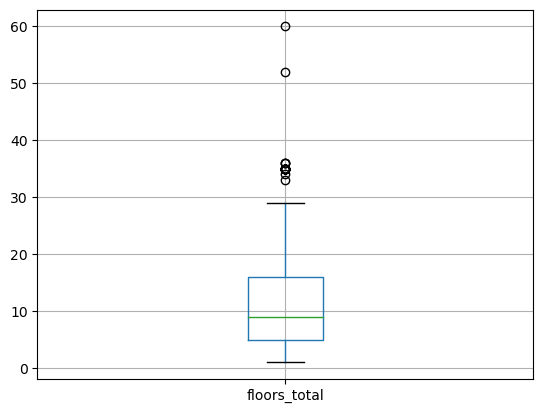

In [55]:
data.boxplot('floors_total')

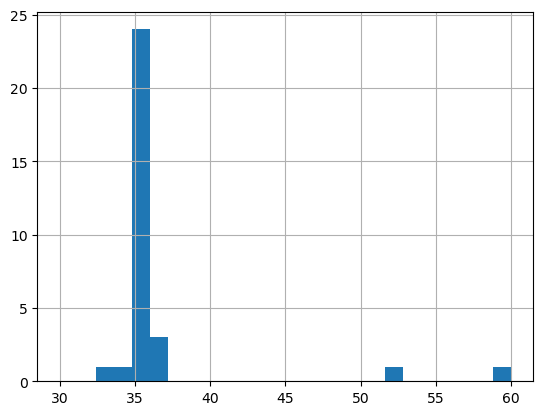

In [56]:
data['floors_total'].hist(bins=25, range=(30, 60));

In [57]:
data.query('floors_total > 35')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
397,15,5990000.0,54.0,2018-03-22,2,2.65,36,21.4,28,False,...,18.7,1,санкт-петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,11.0
2247,12,3800000.0,45.5,2018-06-28,2,2.88,60,27.4,4,False,...,7.4,0,кронштадт,67763.0,49488.0,2.0,342.0,3.0,614.0,166.0
5789,17,8150000.0,80.0,2019-01-09,2,2.70,36,41.0,13,False,...,12.0,5,санкт-петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0
11050,16,9200000.0,75.0,2019-02-22,2,2.70,36,40.0,29,False,...,12.0,2,санкт-петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,NaN
16684,9,3978000.0,40.0,2018-09-24,1,2.65,52,10.5,18,False,...,14.0,0,санкт-петербург,20728.0,12978.0,1.0,793.0,0.0,NaN,45.0


In [58]:
floors_total = data.loc[data.loc[:, 'floors_total'] > 35]['floors_total']
print(floors_total.unique())
data = data[~data['floors_total'].isin([36, 60, 52])]

[36 60 52]


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23137 entries, 0 to 23617
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23137 non-null  int64         
 1   last_price            23137 non-null  float64       
 2   total_area            23137 non-null  float64       
 3   first_day_exposition  23137 non-null  datetime64[ns]
 4   rooms                 23137 non-null  int64         
 5   ceiling_height        23137 non-null  float64       
 6   floors_total          23137 non-null  int32         
 7   living_area           21285 non-null  float64       
 8   floor                 23137 non-null  int64         
 9   is_apartment          23137 non-null  bool          
 10  studio                23137 non-null  bool          
 11  open_plan             23137 non-null  bool          
 12  kitchen_area          20934 non-null  float64       
 13  balcony         

In [60]:
   (
        data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
              'floor', 'floors_total']]
        .apply (['count', 'min', 'max', 'median'])   
        .style.format("{:,.2f}")
    )

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,137.00","23,137.00","23,137.00","20,057.00","23,137.00","21,285.00","20,934.00","23,137.00","23,137.00"
min,1.00,20.00,2.50,1.00,"12,190.00",10.00,4.00,1.00,1.00
max,6.00,250.00,3.60,"1,580.00","330,000,000.00",200.00,60.00,33.00,35.00
median,2.00,51.80,2.65,95.00,"4,600,000.00",30.00,9.00,4.00,9.00


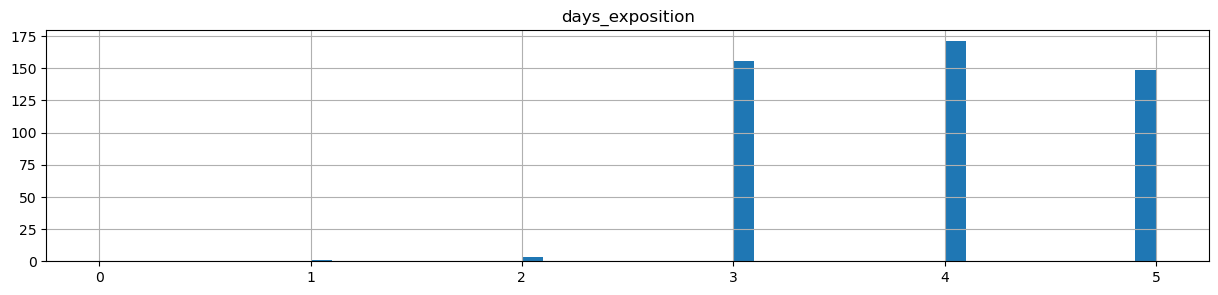

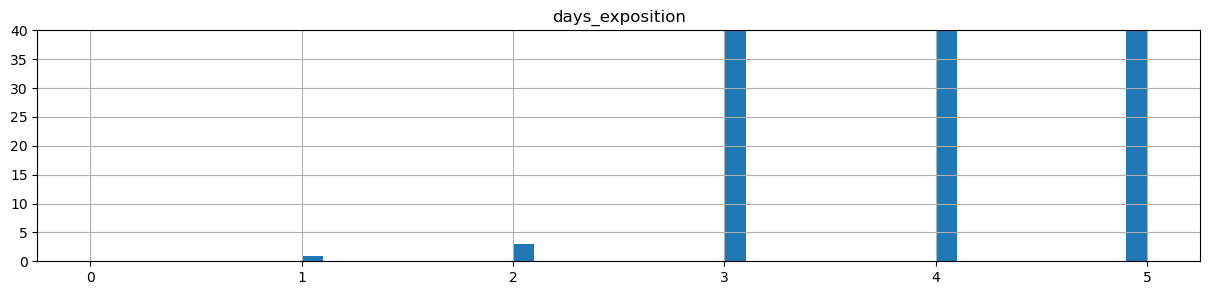

In [61]:
# check
data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5));

data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5))
plt.ylim(0, 40);

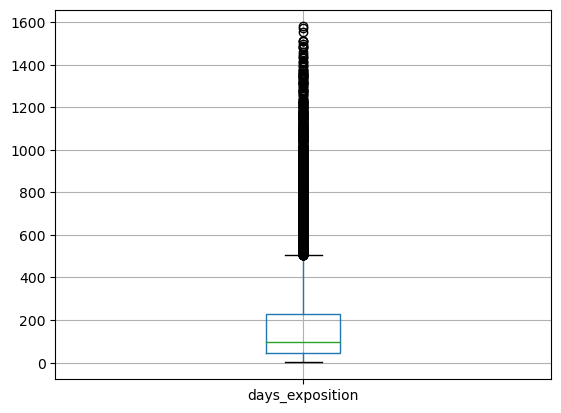

In [62]:
data.boxplot('days_exposition');

In [63]:
data['days_exposition'].describe()

count    20057.000000
mean       179.853817
std        218.934833
min          1.000000
25%         45.000000
50%         95.000000
75%        229.000000
max       1580.000000
Name: days_exposition, dtype: float64

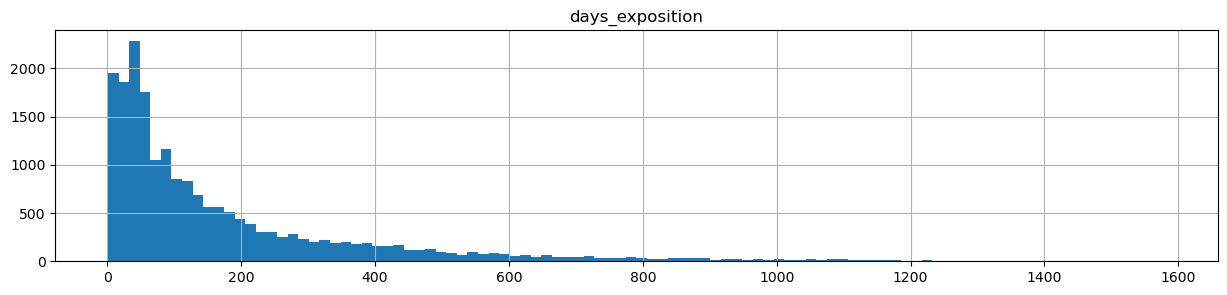

In [64]:
data.hist(column = 'days_exposition', bins = 100, figsize = (15,3));

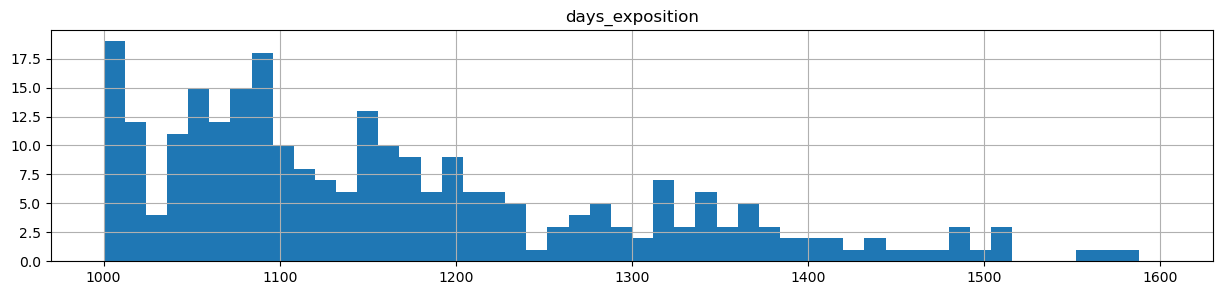

In [65]:
data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range=(1000, 1600));

In [66]:
(
    data[['days_exposition', 'last_price']]
    .quantile([0.0012, 0.01, .5, .99, .998]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,days_exposition,last_price
0.001200,3.00,"563,816.00"
0.010000,4.00,"1,000,000.00"
0.500000,95.00,"4,600,000.00"
0.990000,"1,065.44","28,963,640.00"
0.998000,"1,331.22","55,935,799.07"


In [67]:
data.query('days_exposition > 1330')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
398,7,12789000.0,79.30,2014-12-09,2,3.00,8,43.10,5,False,...,17.60,0,санкт-петербург,39393.0,11096.0,1.0,537.0,0.0,NaN,1345.0
520,20,25717300.0,230.10,2015-01-21,3,2.65,3,130.00,1,False,...,26.10,1,пушкин,16877.0,29030.0,2.0,676.0,3.0,278.0,1441.0
747,6,4150000.0,30.80,2015-03-19,1,2.60,17,15.40,3,False,...,8.70,0,санкт-петербург,32968.0,14132.0,1.0,157.0,1.0,232.0,1336.0
1105,1,34878556.0,95.80,2014-12-09,2,2.65,6,58.30,5,True,...,20.00,1,санкт-петербург,21860.0,318.0,2.0,160.0,3.0,569.0,1572.0
1880,2,13300000.0,79.60,2014-12-09,2,3.00,8,42.70,7,False,...,18.00,0,санкт-петербург,39393.0,11096.0,1.0,537.0,0.0,NaN,1513.0
2932,3,10090000.0,71.90,2015-02-02,2,2.65,10,34.10,9,False,...,16.80,2,санкт-петербург,23604.0,5294.0,0.0,NaN,1.0,434.0,1458.0
3714,16,28000000.0,188.00,2015-06-09,5,3.40,6,139.00,5,False,...,NaN,0,санкт-петербург,25069.0,3771.0,1.0,135.0,1.0,618.0,1395.0
4099,1,8721680.0,58.30,2015-03-10,1,2.65,9,NaN,7,False,...,NaN,0,санкт-петербург,23604.0,5294.0,0.0,NaN,1.0,434.0,1373.0
4721,11,6650000.0,68.30,2015-02-19,4,2.63,5,45.10,4,False,...,9.00,0,санкт-петербург,20182.0,1724.0,3.0,606.0,3.0,453.0,1477.0
5986,4,4400000.0,38.63,2015-02-03,1,2.85,25,15.00,6,False,...,12.30,2,поселок парголово,52611.0,18783.0,0.0,NaN,0.0,NaN,1452.0


In [68]:
days_exposition = data.loc[data.loc[:, 'days_exposition'] > 1330]['days_exposition']
print(days_exposition.unique())
data = data[~data['days_exposition'].isin([1345., 1441., 1336., 1572., 1513., 1458., 1395., 1373., 1477., 1452., 1512., 1406.,
 1344., 1355., 1553., 1434., 1391., 1362., 1484., 1417., 1375., 1368., 1363., 1350.,
 1341., 1497., 1430., 1489., 1346., 1361., 1396., 1580., 1485., 1332., 1413., 1349.,
 1334., 1360.])]

[1345. 1441. 1336. 1572. 1513. 1458. 1395. 1373. 1477. 1452. 1512. 1406.
 1344. 1355. 1553. 1434. 1391. 1362. 1484. 1417. 1375. 1368. 1363. 1350.
 1341. 1497. 1430. 1489. 1346. 1361. 1396. 1580. 1485. 1332. 1413. 1349.
 1334. 1360.]


In [69]:
days_exposition = data.loc[data.loc[:, 'days_exposition'] < 3]['days_exposition']
print(days_exposition.unique())
data = data[~data['days_exposition'].isin([1., 2.])]

[1. 2.]


In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23112 entries, 0 to 23617
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23112 non-null  int64         
 1   last_price            23112 non-null  float64       
 2   total_area            23112 non-null  float64       
 3   first_day_exposition  23112 non-null  datetime64[ns]
 4   rooms                 23112 non-null  int64         
 5   ceiling_height        23112 non-null  float64       
 6   floors_total          23112 non-null  int32         
 7   living_area           21264 non-null  float64       
 8   floor                 23112 non-null  int64         
 9   is_apartment          23112 non-null  bool          
 10  studio                23112 non-null  bool          
 11  open_plan             23112 non-null  bool          
 12  kitchen_area          20911 non-null  float64       
 13  balcony         

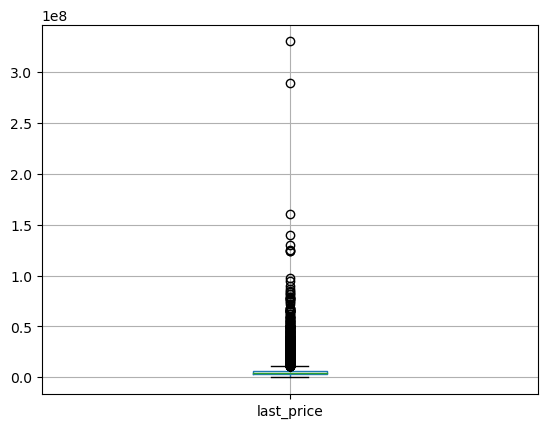

In [71]:
data.boxplot('last_price');

In [72]:
display(data['last_price'].describe())

count    2.311200e+04
mean     6.054302e+06
std      6.521876e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.600000e+06
75%      6.650000e+06
max      3.300000e+08
Name: last_price, dtype: float64

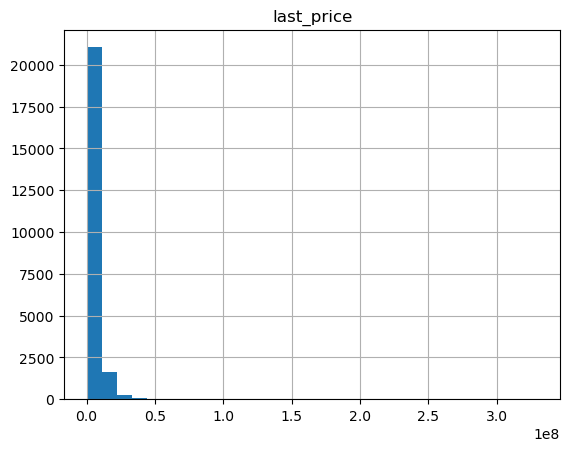

In [73]:
data.hist('last_price', bins=30, range = (0, 3.300000e+08));

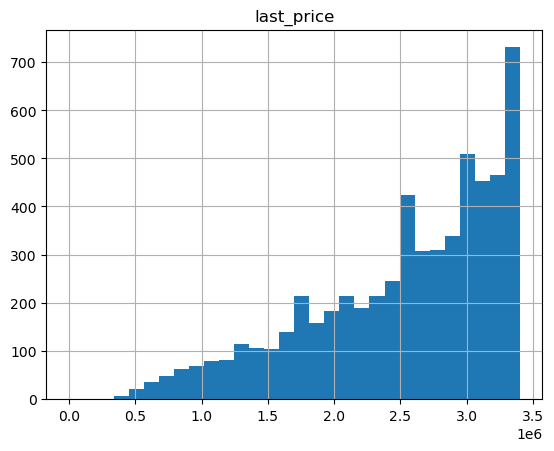

In [74]:
data.hist('last_price', bins=30, range = (0, 3.400000e+06));

In [75]:
(
    data[['last_price']]
    .quantile([0.001, 0.01, .5, .99, .999]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,last_price
0.001000,"550,000.00"
0.010000,"1,000,000.00"
0.500000,"4,600,000.00"
0.990000,"28,888,110.00"
0.999000,"73,819,625.00"


In [76]:
last_price = data.loc[data.loc[:, 'last_price'] < 550000]['last_price']
print(last_price.unique())
data = data[~data['last_price'].isin([12190.])]

[500000. 450000. 490000.  12190. 530000. 430000. 480000. 440000. 470000.
 520000.]


In [77]:
last_price = data.loc[data.loc[:, 'last_price'] > 73740000]['last_price']
print(last_price.unique())
data = data[~data['last_price'].isin([9.000000e+07, 3.300000e+08, 1.250000e+08, 7.700000e+07, 1.240000e+08,
 7.761208e+07, 7.500000e+07, 8.200000e+07, 7.900000e+07, 8.382000e+07,
 9.500000e+07, 8.500000e+07, 7.933900e+07, 8.673880e+07, 1.400000e+08,
 1.300000e+08, 7.734900e+07, 9.800000e+07, 1.600000e+08, 7.400000e+07,
 1.243500e+08, 8.196000e+07, 2.892384e+08])]

[9.000000e+07 3.300000e+08 1.250000e+08 7.700000e+07 1.240000e+08
 7.761208e+07 7.500000e+07 8.200000e+07 7.900000e+07 8.382000e+07
 9.500000e+07 8.500000e+07 7.933900e+07 8.673880e+07 1.400000e+08
 1.300000e+08 7.734900e+07 9.800000e+07 1.600000e+08 7.400000e+07
 1.243500e+08 8.196000e+07 2.892384e+08]


In [78]:
   (
        data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
              'floor', 'floors_total']]
        .apply (['count', 'min', 'max'])   
        .style.format("{:,.2f}")
    )

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,087.00","23,087.00","23,087.00","20,013.00","23,087.00","21,242.00","20,889.00","23,087.00","23,087.00"
min,1.00,20.00,2.50,3.00,"430,000.00",10.00,4.00,1.00,1.00
max,6.00,250.00,3.60,"1,553.00","72,375,000.00",200.00,60.00,33.00,35.00


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23087 entries, 0 to 23617
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23087 non-null  int64         
 1   last_price            23087 non-null  float64       
 2   total_area            23087 non-null  float64       
 3   first_day_exposition  23087 non-null  datetime64[ns]
 4   rooms                 23087 non-null  int64         
 5   ceiling_height        23087 non-null  float64       
 6   floors_total          23087 non-null  int32         
 7   living_area           21242 non-null  float64       
 8   floor                 23087 non-null  int64         
 9   is_apartment          23087 non-null  bool          
 10  studio                23087 non-null  bool          
 11  open_plan             23087 non-null  bool          
 12  kitchen_area          20889 non-null  float64       
 13  balcony         

In [80]:
# check

try:
    df_check = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
# если не получилось прочитать файл из локальной папки, то загружаем данные из сети
except:
    df_check = pd.read_csv('real_estate_data.csv', sep='\t')

In [81]:
# check
df_check.rooms.value_counts().to_frame()

,rooms
1,8047
2,7940
3,5814
4,1180
5,326
0,197
6,105
7,59
8,12
9,8


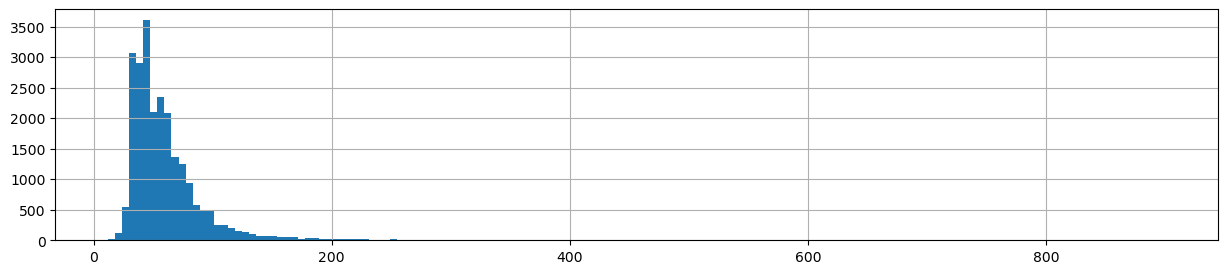

In [82]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3));

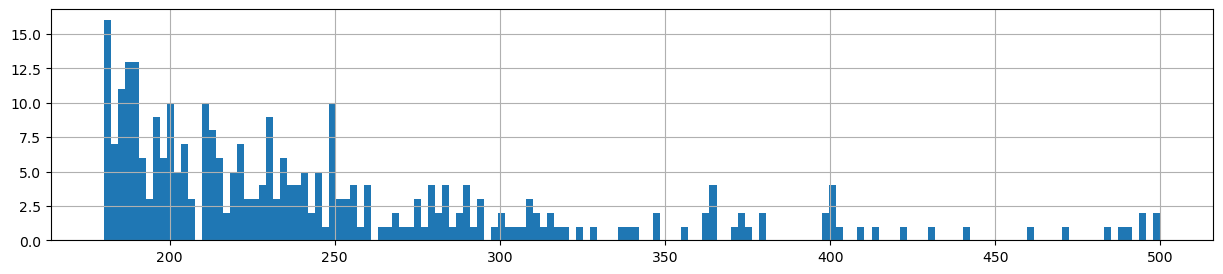

In [83]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

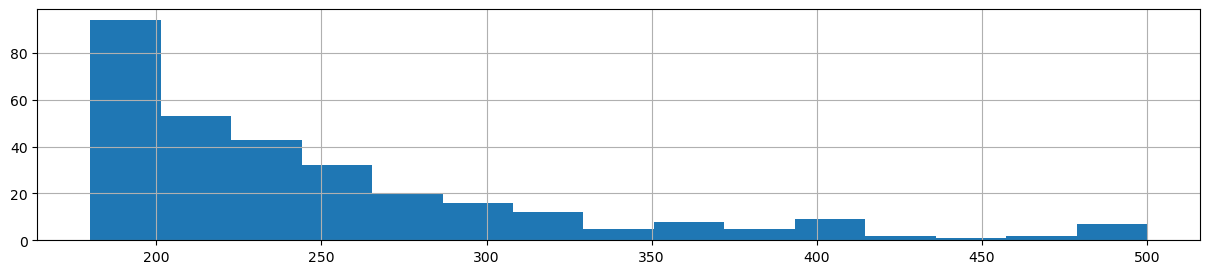

In [84]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (180,500));

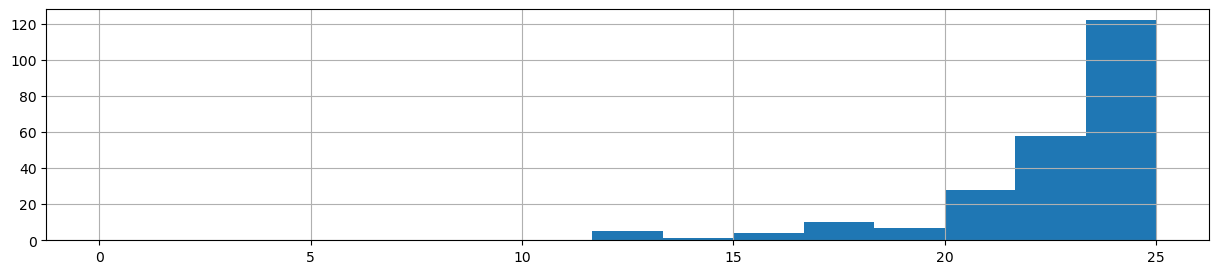

In [85]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (0,25));

In [86]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.001200,1.00,21.90,2.50,3.00,"575,548.00",10.00,4.10,1.00,1.00
0.010000,1.00,26.00,2.50,4.00,"1,000,000.00",13.17,5.00,1.00,2.00
0.500000,2.00,51.70,2.65,95.00,"4,600,000.00",30.00,9.00,4.00,9.00
0.990000,5.00,164.66,3.40,"1,047.88","27,600,000.00",98.00,32.10,23.00,26.00
0.998800,6.00,221.30,3.60,"1,314.00","53,859,360.00",146.27,48.00,26.00,28.00


### Посчитайте и добавьте в таблицу новые столбцы

#### Расчет цены одного квадратного метра

Для расчета стоимости квадратного метра необходимо разделить стоимость на общую площадь. Для удобства последующей работы с данными переведем их в целые числа. Данные сохраним в столбце price_per_square_meter.

In [87]:
data['price_per_square_meter'] = data['last_price'] / data['total_area']
data['price_per_square_meter'] = data['price_per_square_meter'].astype('int')
display(data.head(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,2,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,NaN,9,False,...,0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000


Определим день недели публикации и добавим столбец с информацией об этом.

In [88]:
data['weekday'] = data['first_day_exposition'].dt.weekday # применяем метод для нахождения дня (где 0 — пон., 1 — вт. и т.д.)
display(data['weekday']) #проверяем

0        3
1        1
2        3
3        4
4        1
        ..
23612    4
23614    0
23615    6
23616    1
23617    4
Name: weekday, Length: 23087, dtype: int64

Определим месяц и год публикации объявления и добавим столбцы с информацией об этом.

In [89]:
data['month'] = data['first_day_exposition'].dt.month # применяем метод для нахождения месяца 
print(data['month'].head(5)) #проверяем

0     3
1    12
2     8
3     7
4     6
Name: month, dtype: int64


In [90]:
data['year'] = data['first_day_exposition'].dt.year # применяем метод для нахождения года
print(data['year'].head(5)) #проверяем

0    2019
1    2018
2    2015
3    2015
4    2018
Name: year, dtype: int64


Определим тип этажа квартиры (значения — «первый», «последний», «другой») и запишем данные в столбец floor_type. 

In [91]:
def floor_type(row): #напишем функцию для распределения этажей
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    elif 1 < row['floor'] < row['floors_total']:
        return 'другой'
    

In [92]:
data['floor_type'] = data.apply(floor_type, axis=1) # добавим значения функции в новый столбец с помощью метода apply 
print(data['floor_type']) 

0        другой
1        первый
2        другой
3        другой
4        другой
          ...  
23612    другой
23614    другой
23615    первый
23616    другой
23617    первый
Name: floor_type, Length: 23087, dtype: object


И, наконец, определим расстояние до центра города в километрах. Прежде всего переведем данные из метров в километры и округлим их до целых значений.

In [93]:
data['city_centres_km'] = round(data['city_centers_nearest'] / 1000, 0) #создаем новый столбец и записываем в нем значения в км
print(data['city_centres_km'].head(10))
data.info() #проверяем

0    16.0
1    19.0
2    14.0
3     7.0
4     8.0
5     NaN
6    19.0
7    12.0
8     NaN
9    15.0
Name: city_centres_km, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23087 entries, 0 to 23617
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            23087 non-null  int64         
 1   last_price              23087 non-null  float64       
 2   total_area              23087 non-null  float64       
 3   first_day_exposition    23087 non-null  datetime64[ns]
 4   rooms                   23087 non-null  int64         
 5   ceiling_height          23087 non-null  float64       
 6   floors_total            23087 non-null  int32         
 7   living_area             21242 non-null  float64       
 8   floor                   23087 non-null  int64         
 9   is_apartment            23087 non-null  bool          
 10  studio                  2308

### Проведите исследовательский анализ данных

#### Детальное изучение отдельных параметров и построение гистограмм
 
Постройте отдельные гистограммы для каждого из этих параметров. Опишите все ваши наблюдения по параметрам в ячейке с типом markdown.

общая площадь;
жилая площадь;
площадь кухни;
цена объекта;
количество комнат;
высота потолков;
этаж квартиры;
тип этажа квартиры («первый», «последний», «другой»);
общее количество этажей в доме;
расстояние до центра города в метрах;
расстояние до ближайшего аэропорта;
расстояние до ближайшего парка;
день и месяц публикации объявления.


array([[<AxesSubplot:title={'center':'total_area'}>]], dtype=object)

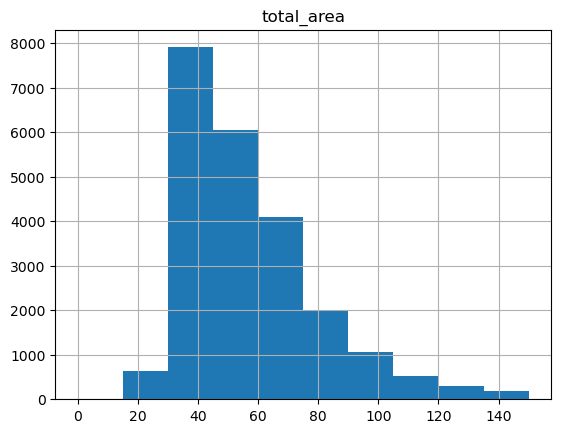

In [94]:
data['total_area'].describe()  # смотрим среднее и медиану с помощью метода describe()
data.hist('total_area', bins=10, range=(0,150))  # строим гистограмму

Распределение на графике похоже на распределение Пуассона. График демонстрирует, что болишнство квартир по площади находятся в диапазоне от примерно 25 до 45м2. Значительную часть выборки также составляю квартиры площадью от 45 до 60м2. Разница в медиане и среднем говорит о наличии "выбросов", к которым мы можем причислить значения, превышающие 200м2. Их всего 224 (около 1%).

Медиана: 30.0
Среднее: 33.27
Минимальное значение: 10.0
Максимальное значение: 200.0


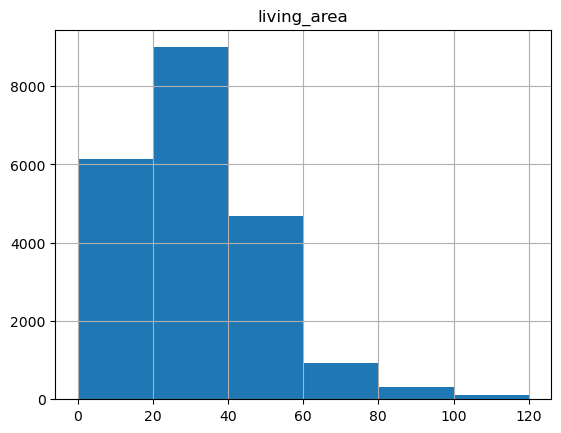

In [95]:
print('Медиана:', round(data['living_area'].median(), 2))
print('Среднее:', round(data['living_area'].mean(), 2))
print('Минимальное значение:', data['living_area'].min())
print('Максимальное значение:', data['living_area'].max())
data.hist('living_area', bins=6, range=(0, 120)); # строим гистограмму

График демонстрирует, что большинство квартир имеют жилую площадь от примерно 20 до 40м2, также большое количество и квартир имеют до 20м2 и от 40 до 60м2. Предложений с жилой площадью более 60м2 - менее 2000 от общего числа, а с площадью более 120м2 - всего 25, поэтому мы можем рассматривать их как "выбросы". Распределение напоминает распределение Пуассона.

Медиана: 9.0
Среднее: 10.35
Минимальное значение: 4.0
Максимальное значение: 60.0


array([[<AxesSubplot:title={'center':'kitchen_area'}>]], dtype=object)

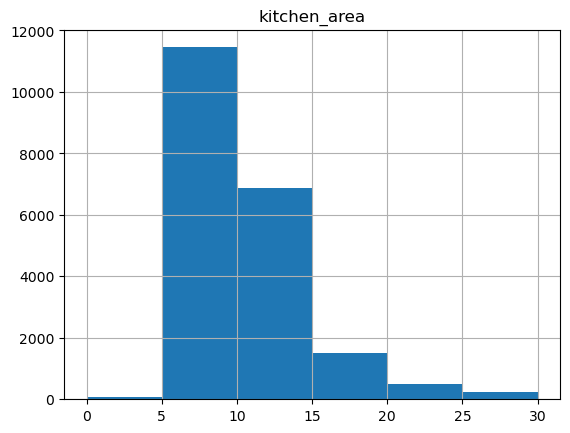

In [96]:
print('Медиана:', data['kitchen_area'].median())
print('Среднее:', round(data['kitchen_area'].mean(), 2))
print('Минимальное значение:', data['kitchen_area'].min())
print('Максимальное значение:', data['kitchen_area'].max())
data.hist('kitchen_area', bins=6, range=(0, 30))

Большинство кухонь или кухонных зон занимают от чуть более 5 до 10м2. Чуть реже встречаются кухни от 10 до 15м2. В общей сложности чуть более 10% кухонь имеют размер от 15 до 30м2. Кухни менее 5 и более 30м2 встречаются крайне редко и приходятся на 105 и 320 объявлений от общего числа. Распределение также напоминает распределение Пуассона.

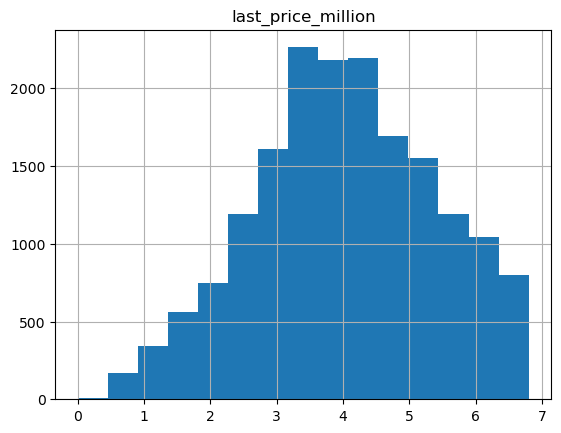

In [97]:
data['last_price_million'] = data['last_price'] / 1000000
data['last_price_million'].describe()  # смотрим общие данные по столбцу, включая среднее и медиану    
#data['last_price'] = data['last_price'].replace(12190.0, 1219000) # заменяем выбивающееся значение на более правдоподобное
data.hist('last_price_million', bins=15, range=(0, 6.799000)); # строим гистограмму
                      

Большинство квартир находятся в диапазоне от 4 до 8млн, вторая по популярности - от менее млн до 4 млн. От 8 до 12млн. чуть более 2000 объектов. Объекты стоимостью более 12млн. составляют менее 2000.  Распределение напоминает распределение Пуассона. Данные сильно смещены влево из-за наличия небольшого количества значительно более дорогих квартир, чем большинство. Об этом свидетельствует разница между медианным и средним значением. Выбросами можно считать квартиры стоимостью более 25млн (их всего 242).

Рассмотрим количество комнат.

count    23087.000000
mean         2.040672
std          0.973859
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64

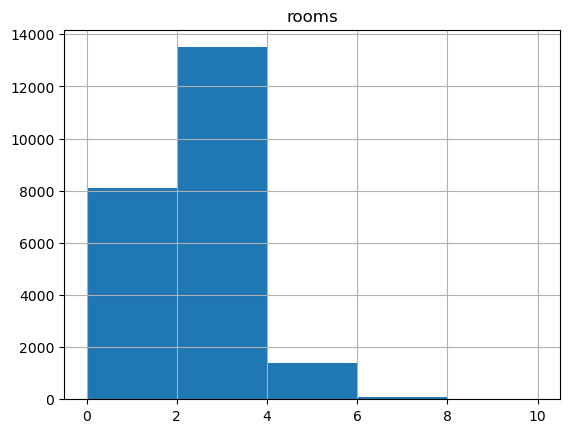

In [98]:
data.query('rooms == 0 and is_apartment == True') # делаем срез, чтобы проверить гипотезу о том, что число комнат, равное 0, характерно для апартаментов
#data.query('rooms > 4') # делаем срез, чтобы проверить, сколько квартир имеют более 4 комнат
data.hist('rooms', bins = 5, range=(0, 10)) # строим гистограмму
data['rooms'].describe()

Большинство квартир имеют от 2 до 4 комнаты. Преобладающее значение - 2 комнаты, что подтверждает совпадение медианного и среднего значений.  Следует обратить внимание на то, что есть значения 0 комнат. Они характеры для апартаментов. Но их всего 190, так что они не влияют на общую картину. Второй по значимости можно назвать группу квартир с 1 комнатой. Значительно меньше квартир с  более 4 комнатами (всего 518). Их можно считать выбросами, как и нулевые значения. Распределение также напоминает распределение Пуассона. Наблюдается смещение данных влево. Это объясняется тем, что кватир с небольшим числом комнат больше.

count    23087.000000
mean         2.684365
std          0.178796
min          2.500000
25%          2.600000
50%          2.650000
75%          2.700000
max          3.600000
Name: ceiling_height, dtype: float64

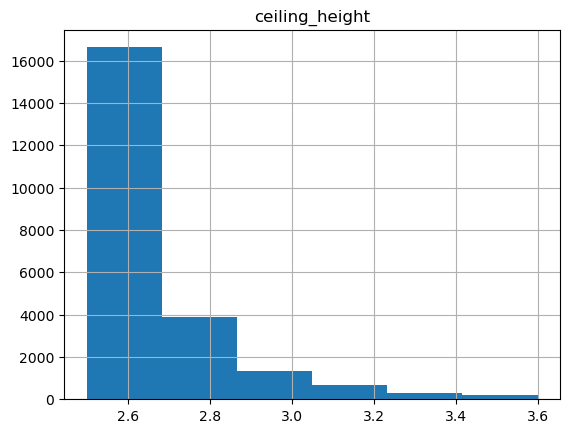

In [99]:
data.hist('ceiling_height', bins=6) # строим гистограмму
data['ceiling_height'].describe() # Исследуем высоту потолков

Судя по графику, большинство квартир имеют высоту потолков от 2,5 до 3 метров. Медианное и среднее значения в данном случае практически идентичны - 2,65 и 2,69 соответственно. Но нужно учесть, что ранее мы заполнили пропущенные значения медианной высотой потолка, равной 2,65м. Распределение напоминает распределение Пуассона.
Предположительно, можно расссматривать данные, где значение превышает 4,5м, как выбросы. 

Рассмотрим распределение по этажам и типам этажей.

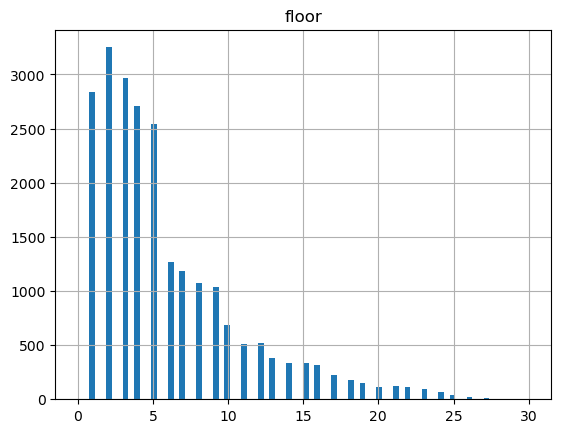

In [100]:
data.hist('floor', bins=80, range=(0, 30)); # строим гистограмму

In [101]:
data['floor'].describe() # изучаем данные по этажам

count    23087.000000
mean         5.922944
std          4.894866
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

In [102]:
data[data['floor'] > 16] # делаем срез по квартирам, которые находятся выше 16 этажа

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday,month,year,floor_type,city_centres_km,last_price_million
7,5,7915000.0,71.60,2019-04-18,2,2.65,24,NaN,22,False,...,0.0,NaN,NaN,110544,3,4,2019,другой,12.0,7.915000
8,20,2900000.0,33.16,2018-05-23,1,2.65,27,15.43,26,False,...,NaN,NaN,189.0,87454,2,5,2018,другой,NaN,2.900000
25,3,6800000.0,76.00,2015-10-01,2,2.75,23,39.00,18,False,...,1.0,564.0,300.0,89473,3,10,2015,другой,15.0,6.800000
40,9,3590000.0,36.00,2017-03-15,1,2.60,26,15.00,22,False,...,0.0,NaN,430.0,99722,2,3,2017,другой,19.0,3.590000
75,19,4950000.0,44.00,2018-02-27,2,2.70,23,21.00,19,False,...,0.0,NaN,36.0,112500,1,2,2018,другой,15.0,4.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23463,3,5000000.0,49.00,2015-03-10,1,2.65,28,NaN,24,False,...,1.0,400.0,943.0,102040,1,3,2015,другой,22.0,5.000000
23468,5,19600000.0,184.00,2016-04-21,3,3.00,19,55.70,19,False,...,0.0,NaN,205.0,106521,3,4,2016,последний,5.0,19.600000
23504,1,5953044.0,89.60,2015-09-03,3,2.75,23,47.70,17,False,...,1.0,624.0,939.0,66440,3,9,2015,другой,9.0,5.953044
23509,0,21187872.0,123.30,2017-04-25,3,2.65,1,50.40,18,False,...,0.0,NaN,104.0,171840,1,4,2017,None,5.0,21.187872


Большинство квартир расположены на 1-5 этажах (медианное значение = 4). Это свидетельствует о распострененности малоэтажной застройки в регионе. На втором месте по численности квартиры с 5 по 9 этаж. стандартное отклонение и значительное отличие медианного значения от среднего свидетельствует о том, что квартиры на высоких этажах встречаются редко. В нашем случае квартиры на этаже выше 20 составляют лишь 483 от общего числа. Распределение напоминает распределение Пуассона.

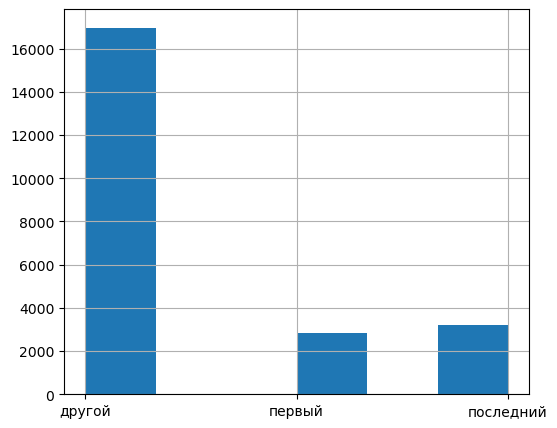

In [103]:
data['floor_type'].hist(bins = 6, grid=True, figsize=(6, 5)); # строим график по типу этажа

Большинство объектов находятся не на первом и не на последнем этаже. 

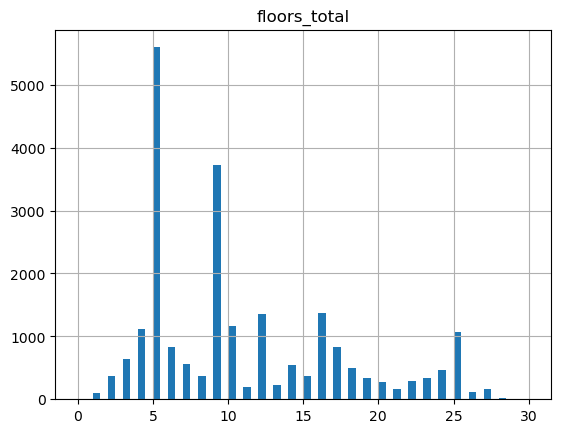

In [104]:
data.hist('floors_total', bins=60, range=(0,30)); # рассмотрим общее количество этажей в доме с помощью построения гистограммы

Исходя из графика, среди продаваемых квартир преобладают квартиры в пятиэтажках и девятиэтажках. Выделяются также 12-этажные, 16-этажные дома и новостройки, где около 25 этажей.

Исследуем расстояние до центра города. Ранее мы установили, что часть данных пропущена и связали это с тем, что в случаях отсутствия данных, продаваемый объект предположительно находится вне города. 

count    17634.000000
mean     14368.907338
std       8556.679196
min        181.000000
25%       9580.500000
50%      13219.000000
75%      16382.500000
max      65968.000000
Name: city_centers_nearest, dtype: float64

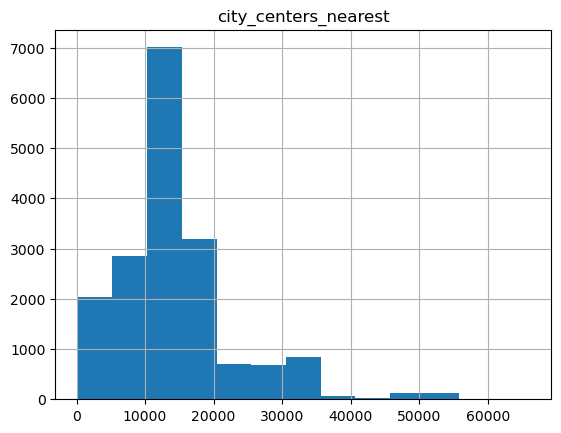

In [105]:
data.hist('city_centers_nearest', bins=13);  # построим гистограмму
data['city_centers_nearest'].describe() # проверим данные по удаленности от центра города

На графике видно, что большинство объектов находятся на рассмоянии 10-15км от города. Также большой процент квартир (в сумме) находится на расстоянии до 5, от 5 до 10 и от 15 до 20км от центра. На расстоянии более 20км находятся около 10% объектов. Распределение похоже на нормальное с наличием выбросов.

count    17614.000000
mean     28878.844669
std      12719.929938
min          0.000000
25%      18459.750000
50%      26947.000000
75%      37412.000000
max      84869.000000
Name: airports_nearest, dtype: float64

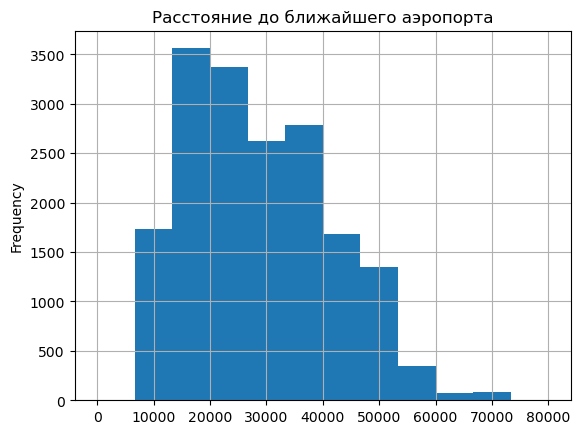

In [106]:
data['airports_nearest'].plot(title = 'Расстояние до ближайшего аэропорта', kind='hist', bins=12, range=(0, 80000), grid=True);
data['airports_nearest'].describe() # проверим данные по удаленности от аэропорта

Большинство объектов находятся на расстоянии от ближайшего аэропорта от 15 до 25км. Менее 500 объектов находятся в непосредственной близости от аэропорта (менее 10 км). В общей сложности чуть меньше 4000 объектов находится на удалении от аэропорта более 40км. Распределение напоминает распределение Пуассона.

count    7727.000000
mean      492.257927
std       343.640998
min         1.000000
25%       288.000000
50%       455.000000
75%       613.000000
max      3190.000000
Name: parks_nearest, dtype: float64

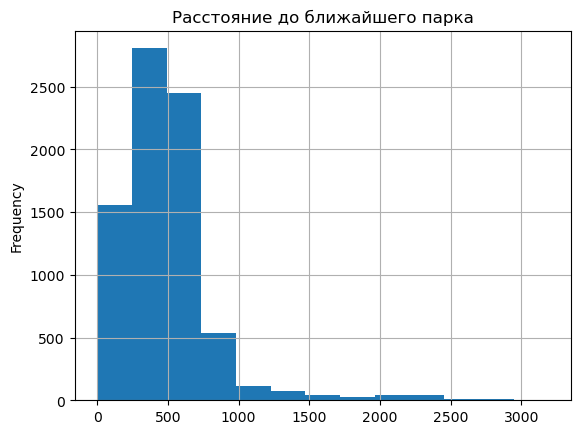

In [107]:
data['parks_nearest'].plot(title = 'Расстояние до ближайшего парка', kind='hist', bins=13, grid=True);
data['parks_nearest'].describe() # проверим данные по удаленности от аэропорта

Данные о расстоянии до ближайшего парка представлены только у 8051 объекта. При этом у 174 объектов расстояние превышает 1,5км. Так как это более 20 минут ходьбы и вряд ли релевантно для покупателя. Эти данные для дальнейшего анализа и могут быть объединены или удалены. Распределение напоминает распределение Пуассона.

count    23087.000000
mean         2.571361
std          1.789375
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: weekday, dtype: float64

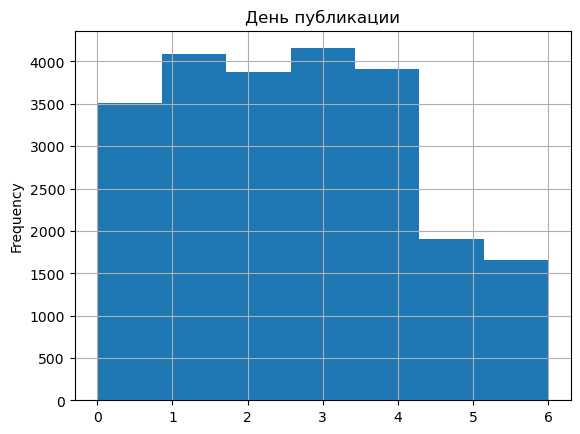

In [108]:
data['weekday'].plot(title = 'День публикации', kind='hist', bins=7, grid=True); 
data['weekday'].describe()

Наименьшее число публикаций наблюдается в выходные дни, а наибольшее - во вторник и четверг.

count    23087.000000
mean         6.401568
std          3.490002
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month, dtype: float64

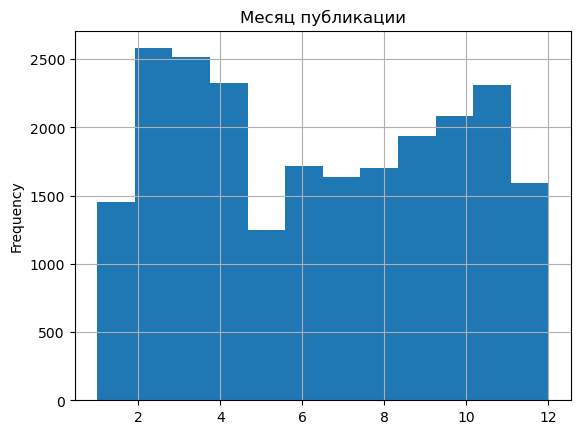

In [109]:
data['month'].plot(title = 'Месяц публикации', kind='hist', bins=12, grid=True);
data['month'].describe()

Наименьшее активность публикаций наблюдается в январе, мае и декабре. А наибольшая - в феврале, марте, апреле и ноябре. Можно отметить тенденцию к снижению числа публикаций с февраля по апрель и рост - с августа по ноябрь. 

#### Скорость продажи

Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление. 
 
Постройте гистограмму.
Посчитайте среднее и медиану.
В ячейке типа markdown опишите, сколько времени обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?

count    20013.000000
mean       178.575176
std        215.582221
min          3.000000
25%         45.000000
50%         95.000000
75%        228.000000
max       1553.000000
Name: days_exposition, dtype: float64

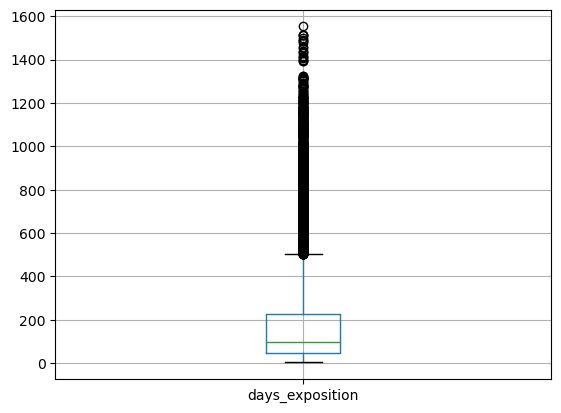

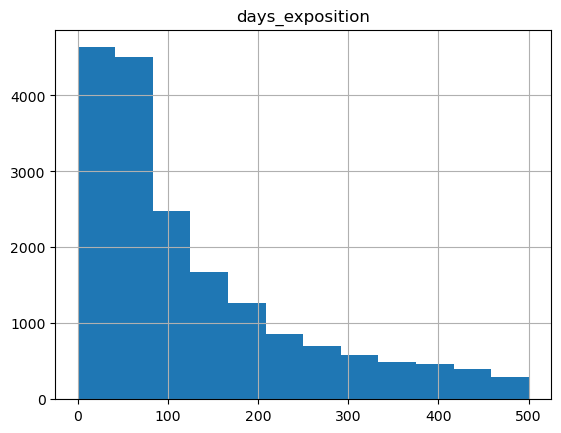

In [110]:
data.boxplot('days_exposition') # строим график ящик с усами, чтобы определить выбросы и убрать их для дальнейшего анализа
data.hist('days_exposition', bins=12, range=(0, 500)); # строи гистограмму без учета выбросов
data['days_exposition'].describe() # смотрим данные по количеству дней размещения

График "ящик с усами" показывает, что значения более 500 являются выбросами, так как не входят в межквартильный размах. Таких образом, можно считать необычно долгими продажи, при которых объявления вывешено более 500 дней. Следовательно, быстрыми можно считать значения первого квартиля (25%) =  до 45 дней. Распределение напоминает распределение Пуассона.

      median
year        
2014   864.0
2015   575.5
2016   235.0
2017   102.0
2018    64.0
2019    24.0


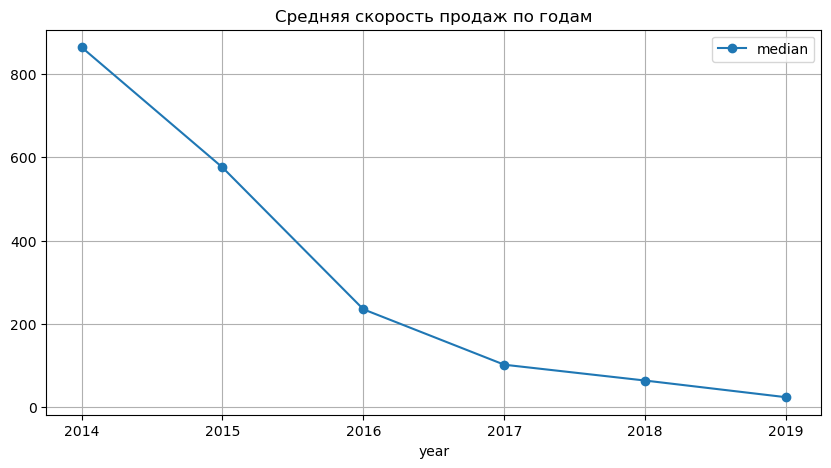

In [111]:
data_by_years = data.pivot_table(index='year', values='days_exposition', aggfunc={'median'}) # cоздаем сводную таблицу с помощью метода pivot_table
print(data_by_years.head(10)) # проверяем
data_by_years.plot(title='Средняя скорость продаж по годам', style='o-', grid=True, figsize=(10,5));

In [112]:
display(data['days_exposition'].mode())

0    45.0
Name: days_exposition, dtype: float64

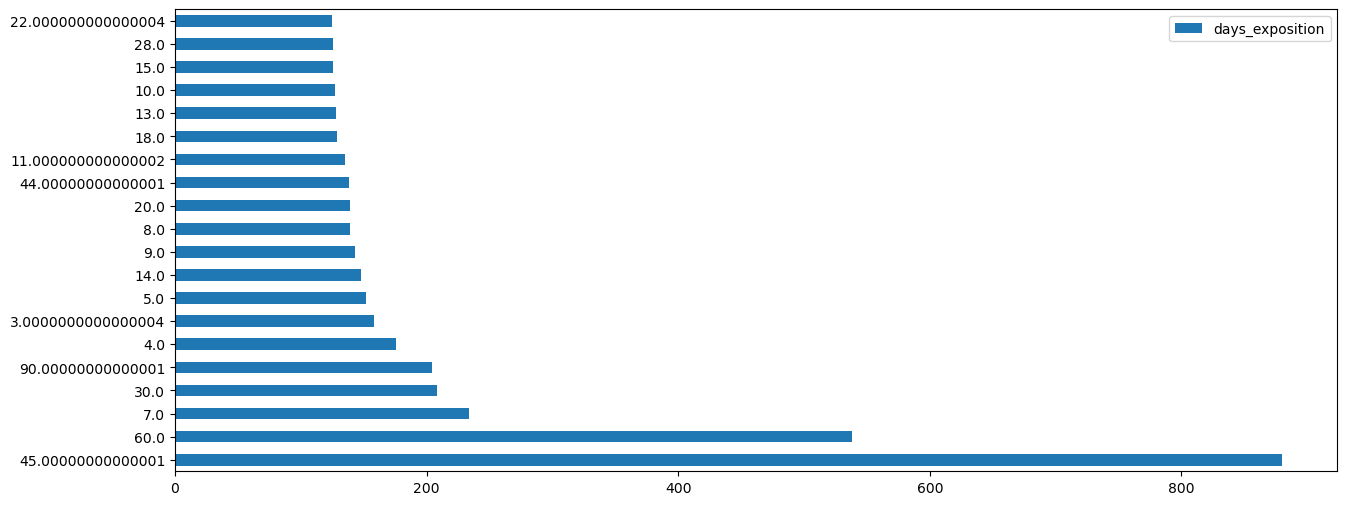

In [113]:
# check
# Моды на реальных данных

df_check = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep = '\t')
    
df_check['days_exposition'].value_counts().to_frame().head(20).plot(kind = 'barh', figsize = (15,6), rot = 0);

#### Какие факторы больше всего влияют на общую (полную) стоимость объекта?
 
Изучите, зависит ли цена от:

общей площади;
жилой площади;
площади кухни;
количества комнат;
этажа, на котором расположена квартира (первый, последний, другой);
даты размещения (день недели, месяц, год).
Постройте графики, которые покажут зависимость цены от указанных выше параметров. 

Выведем для удобства анализа данных свобдную таблицу по необходимым параментрам.

In [114]:
   (
        data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
              'floor', 'floors_total']]
        .apply (['count', 'min', 'max', 'mean', 'median'])   
        .style.format("{:,.2f}")
    )

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,087.00","23,087.00","23,087.00","20,013.00","23,087.00","21,242.00","20,889.00","23,087.00","23,087.00"
min,1.00,20.00,2.50,3.00,"430,000.00",10.00,4.00,1.00,1.00
max,6.00,250.00,3.60,"1,553.00","72,375,000.00",200.00,60.00,33.00,35.00
mean,2.04,58.25,2.68,178.58,"5,942,115.22",33.27,10.35,5.92,10.72
median,2.00,51.70,2.65,95.00,"4,600,000.00",30.00,9.00,4.00,9.00


In [115]:
data_corr_area = data.loc[:, ['last_price', 'total_area', 'living_area', 'kitchen_area']] # используем аттрибут loc 
 # и записываем данные по необходимым столбцам в соответствующие переменные 

              last_price  total_area  living_area  kitchen_area
last_price      1.000000    0.757856     0.653830      0.577942
total_area      0.757856    1.000000     0.927024      0.577763
living_area     0.653830    0.927024     1.000000      0.348738
kitchen_area    0.577942    0.577763     0.348738      1.000000


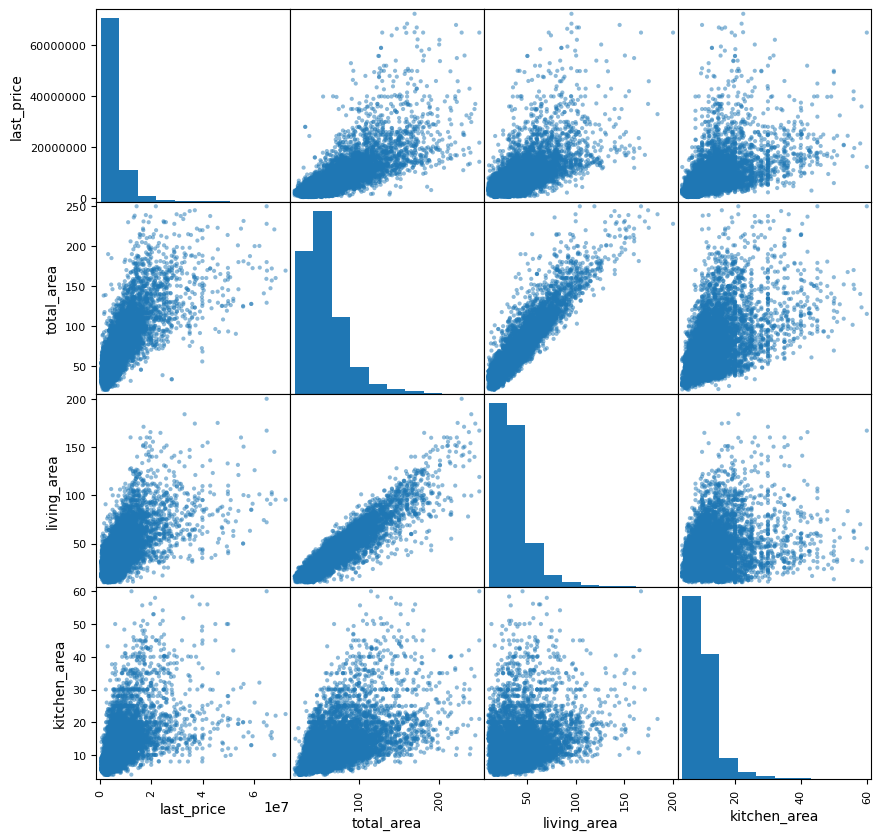

In [116]:
pd.plotting.scatter_matrix(data_corr_area, figsize=(10, 10)) # строим матрицу графиков для визуализации корреляции
print(data_corr_area.corr()) # строим таблицу корреляций по цене и разными параметрами площади объекта

Судя по графикам, наблюдается положительная корреляция между ценой и площадью, как общей, так и жилой зоны и кухни. Однако корреляция не значительная, так как наиболее высокий коэффициент корреляции равен 0.65 (цена с общей площадью). Но данные требует большей детализации. Рассмотрим параметры отдельно.

Напишем функцию для построения графиков зависимости цены и вышеупомянутых факторов, где в качестве аргументов: 
- column - название столбца для оси X
- xrange - пределы значений в столбце column для построения графика
- need_median - необходимость отображения медианы.

Оптимальный вид графика для выявления зависимости - точечный (scatter).

In [117]:
def last_price_graph(column, xrange, need_median=False): 

    ax = data.plot(x = column,
                   y = 'last_price',
                   kind = 'scatter',         # точечный график
                   style = 'o',              # отображение данных точками
                   alpha = 0.2,              # прозрачность
                   figsize = (10, 5),         
                   xlim = xrange,            # пределы по оси x
                   ylim = (0, 3.6*10**7),    # пределы по оси y
                   grid = True               # сетка
                   )
    if need_median:                       # группируем данные по столбцам и находим медианы (делали выше)
        (data                             
         .groupby(column)['last_price']
         .agg(['median']) 
         .plot(ax = ax,                 # приравниваем ось к предыдущей
               y = 'median',
               style = '-or',
               legend = True,          # легенда
               label = 'median',       # название линии
               grid = True             
              )
        )      
        
    plt.show()

##### Влияние общей площади на цену

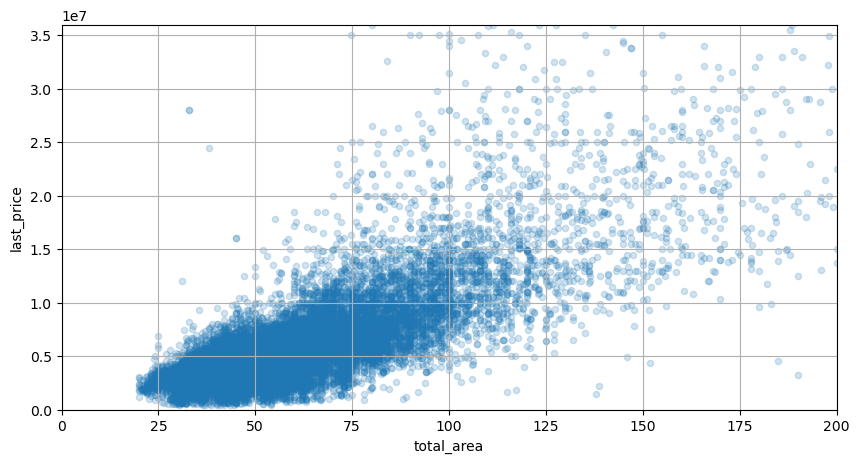

Коэфф. корреляции между last_price и total_area = 0.8


In [118]:
last_price_graph('total_area', xrange=(0, 200)) # построим график c помощью функции
print('Коэфф. корреляции между last_price и total_area =', round(data['last_price'].corr(data['total_area']), 1))
# определим коэффициент корреляции методом corr()

Исходя из графика и коэф. корр. Пирсона, наблюдается прямая зависимость между ценой объекта и общей площадью. 
Наиболее выражена зависимость на примере объектов от примерно 20 до 100 м2.

##### Влияние жилой площади на цену

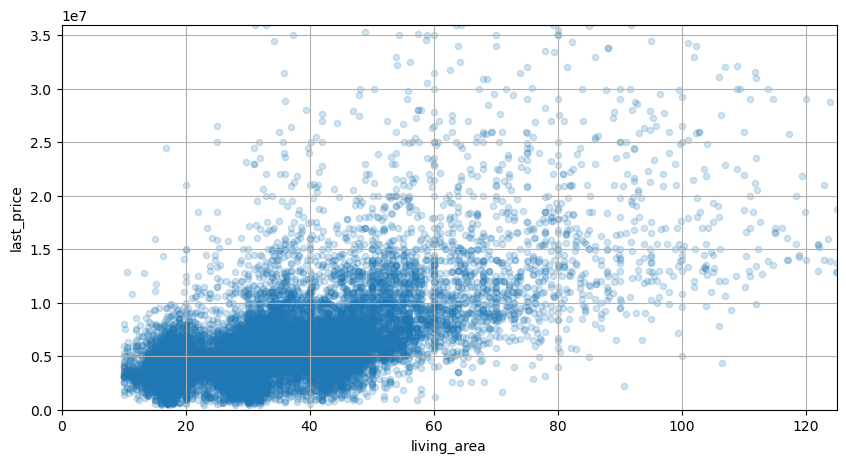

Коэфф. корреляции между last_price и living_area = 0.7


In [119]:
last_price_graph('living_area', xrange=(0, 125)) 
print('Коэфф. корреляции между last_price и living_area =', round(data['last_price'].corr(data['living_area']), 1))

Исходя из графика и коэф. корр. Пирсона, наблюдается прямая, менее сильная, чем в предыдущем случае зависимость между ценой объекта и жилой площадью. 
Наиболее выражена зависимость на примере объектов от примерно 10 до 60 м2.

##### Влияние площади кухни на цену

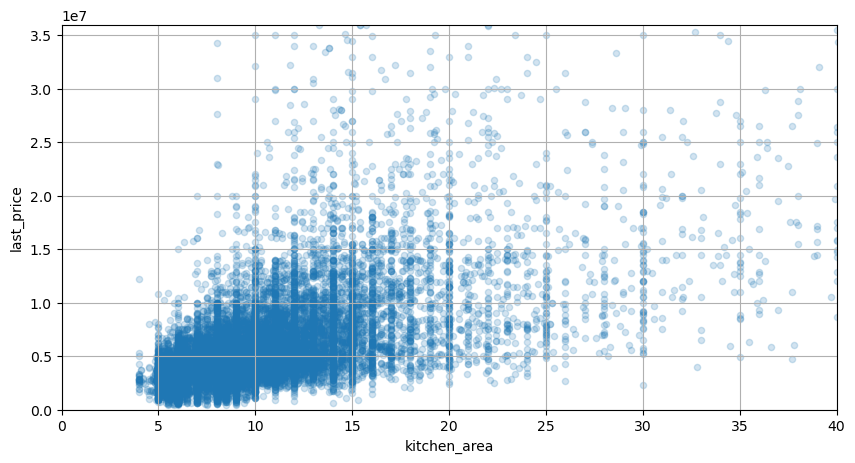

Коэфф. корреляции между last_price и kitchen_area = 0.6


In [120]:
last_price_graph('kitchen_area', xrange=(0, 40)) 
print('Коэфф. корреляции между last_price и kitchen_area =', round(data['last_price'].corr(data['kitchen_area']), 1))

Исходя из графика и коэф. корр. Пирсона, наблюдается слабая зависимость между ценой объекта и площадью кухни. 
Наиболее выражена зависимость на примере объектов  с площаью кухни от 5 до 15 м2.

##### Влияние количества комнат на цену

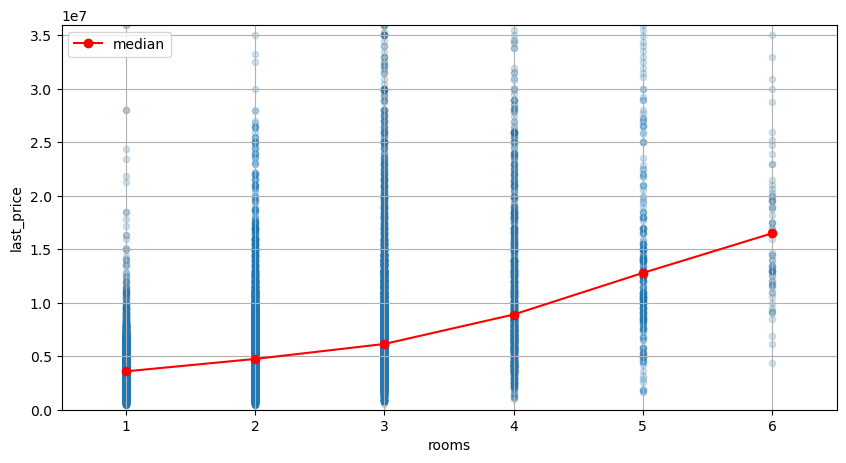

Коэфф. корреляции между last_price и rooms = 0.5


In [121]:
last_price_graph('rooms', xrange=(0.5, 6.5), need_median=True) #отобразим медиану 
print('Коэфф. корреляции между last_price и rooms =', round(data['last_price'].corr(data['rooms']), 1))

Несмотря на то, что медианное значение цены растет с количеством комнат, что объясняется увеличением общей площади объекта, коэф. корр. Пирсона достаточно низкий. Это свидетельствует о слабой зависимость между ценой объекта и количеством комнат. 

##### Влияние дня публикации объявления на цену

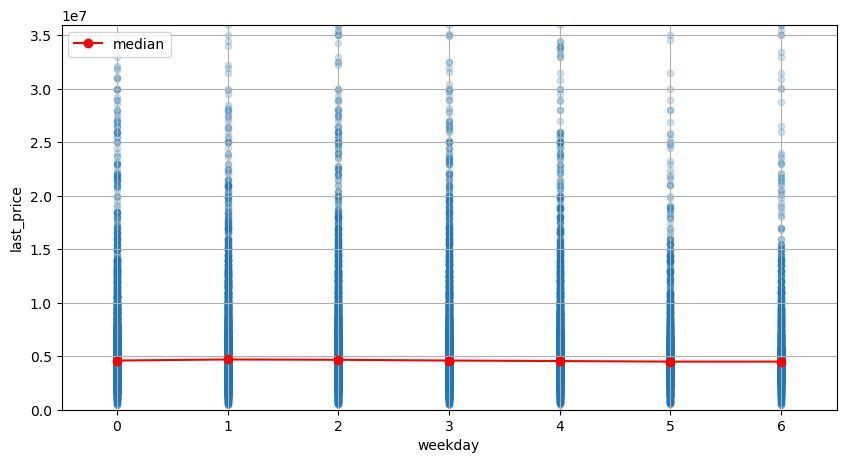

In [122]:
last_price_graph('weekday', xrange=(-0.5, 6.5), need_median=True)

Судя по графику, зависимости между ценой объекта и днем публикации нет. 

##### Влияние месяца публикации объявления на цену

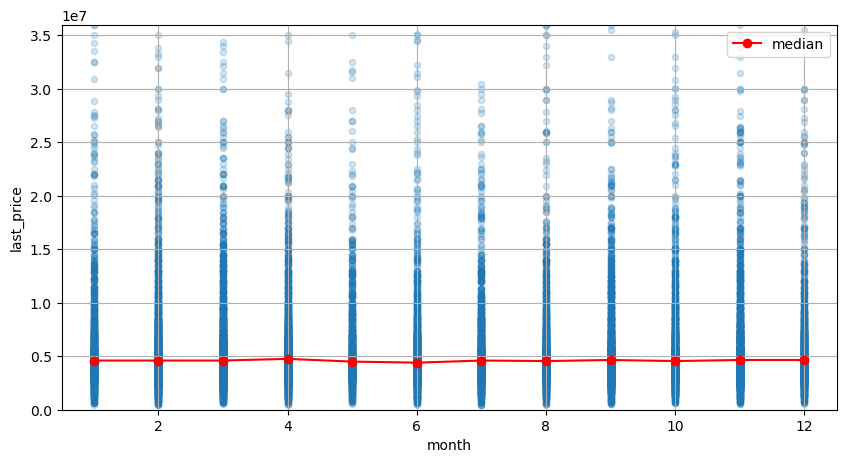

In [123]:
last_price_graph('month', xrange=(0.5, 12.5), need_median=True)

Судя по графику, зависимости между ценой объекта и месяцнм публикации нет. 

##### Влияние года публикации объявления на цену

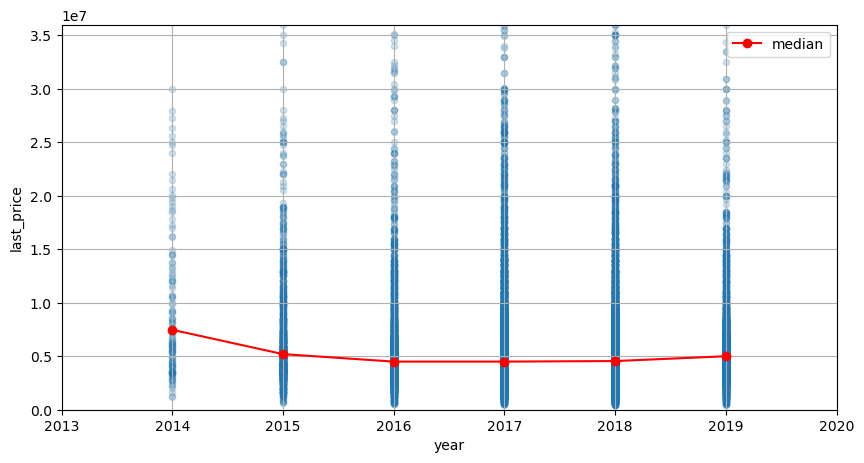

In [124]:
last_price_graph('year', xrange=(2013, 2020), need_median=True)

График демонстрирует отсутсвие зависимости цены от года публикации за единственным исключением. Следует обратить внимание, что с 2014 по 2015 наблюдается снижение цен на квартиры, однако с 2015 по 2019 год медианное значение остается стабильным.

##### Взаимное влияние параметров

Рассмотрим взаимное влияние некотрых параметров параметров: кол-во записей и изменение средней цены и средней площади с 2014 по 2019 гг.

In [125]:
pivot_1 = data.pivot_table(index='year', values='total_area', aggfunc={'median'})
display(pivot_1.rename(columns={'median': 'средняя общ. площадь'}))

,средняя общ. площадь
year,
2014,75.5
2015,59.7
2016,53.0
2017,51.2
2018,50.2
2019,51.3


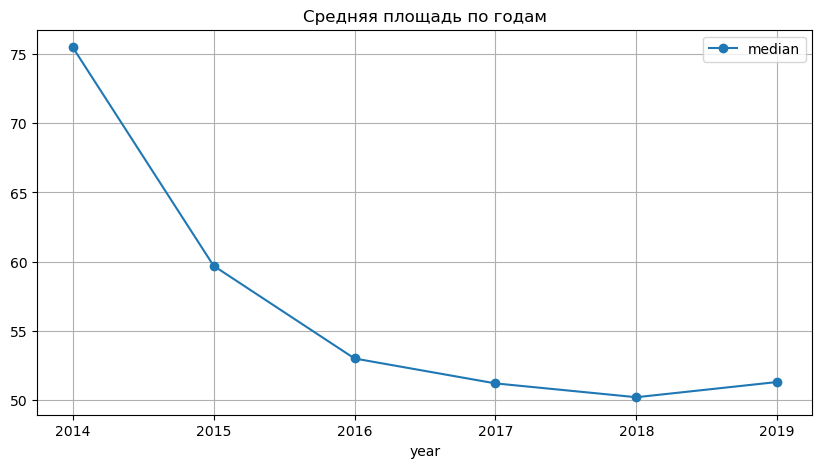

In [126]:
pivot_1.plot(title='Средняя площадь по годам', style='o-', grid=True, figsize=(10,5));

In [127]:
pivot_2 = data.pivot_table(index='year', values='last_price', aggfunc={'median'})
display(pivot_2.rename(columns={'median': 'средняя цена'}))

,средняя цена
year,
2014,7476560.0
2015,5200000.0
2016,4500000.0
2017,4500000.0
2018,4550000.0
2019,5000000.0


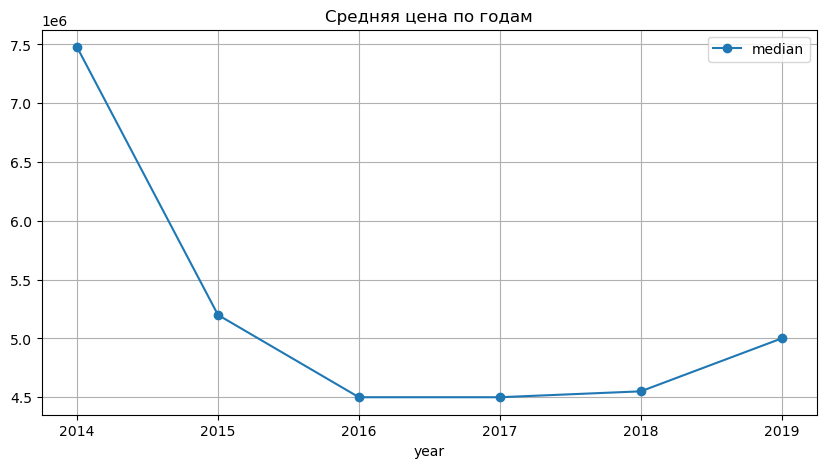

In [128]:
pivot_2.plot(title='Средняя цена по годам', style='o-', grid=True, figsize=(10,5));

In [129]:
pivot_3 = data.pivot_table(index='year', values='last_price', aggfunc={'count'})
display(pivot_3.rename(columns={'count': 'кол-во объявлений'}))

,кол-во объявлений
year,
2014,127
2015,1119
2016,2704
2017,7982
2018,8348
2019,2807


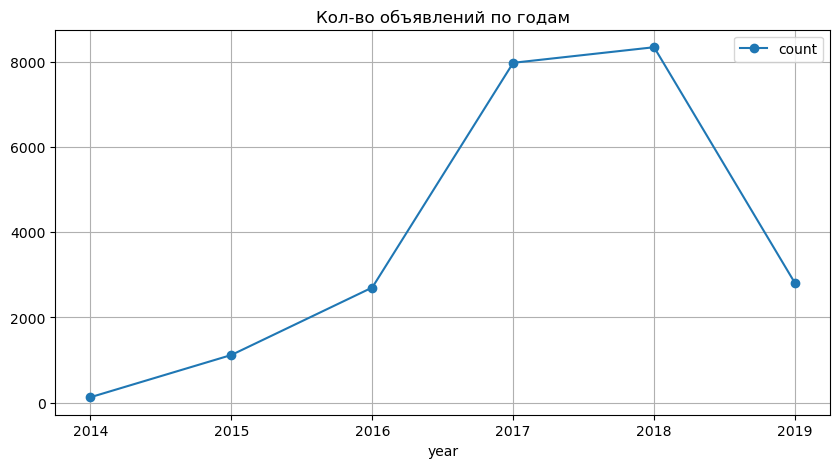

In [130]:
pivot_3.plot(title='Кол-во объявлений по годам', style='o-', grid=True, figsize=(10,5));

Судя по графикам, средняя площадь и цены изменялись относительно равномерно: с 2014 по 2016 наблюдается резкий спад по обоим параметрам - с 75 до 53м2 и с 7,5 до 5,2 млн соответственно. С 2016 по 2018 ситуация несколько изменяется: средняя площадь постепенно уменьшается (с 53 до 50м2), а средняя цена остается примерно на том же уровне (4,5 млн), что говорит о некотором росте стоимости жилья в эти годы. С 2018 по 2019 по обоим параметрам виден рост, однако в отношении цены этот рост более значительный (с 4,5 до 5 млн) при увеличении средней площади жилья всего на 2 м2. 

В отношении количества объявлений ситуация совершенно иная: с 2014 по 2016 виден стабильный рост количества объявлений с 0 до почти 3000 единиц, а с 2016 по 2017 происходит резкий скачок до 8000 объявлений. С 2017 по 2018 количество объявлений находится около этой отметки, однако в 2019 году виден резкий спад до 3000 объявлений. Вероятно, это связано с тем, что при росте цен на недвижимость люди менее склонны к продаже, ожидая более выгодных для себя условий.

#### Расчет средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце locality_name.


In [131]:
top_10 = (data.groupby('locality_name')['price_per_square_meter'].agg(['count', 'mean']).sort_values(by='count', ascending=False)).head(10)
#top_10 = top_10.rename(columns={'mean': 'средняя цена м2', 'count': 'кол-во объявлений'})
display(top_10)
# сгруппируем данные по названию местности методом groupby и применим в качестве функции подсчет и среднее
# применим метод sort_values с параметром ascending=False для расположения их по убыванию

,count,mean
locality_name,,
санкт-петербург,15247,112467.542861
поселок мурино,553,85579.703436
поселок шушары,436,78531.756881
всеволожск,395,68616.592405
пушкин,355,102704.326761
колпино,336,75352.047619
поселок парголово,325,90361.923077
гатчина,306,68799.176471
деревня кудрово,299,92473.086957


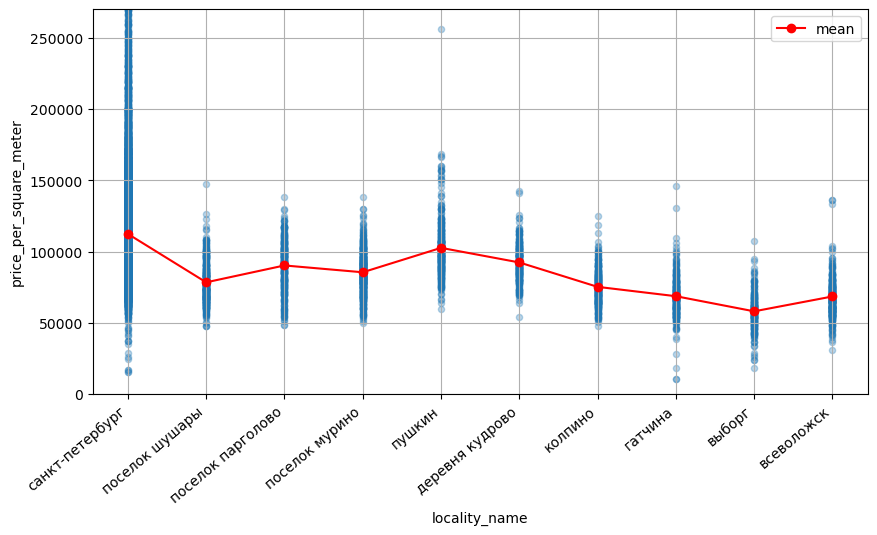

In [132]:
ax = (data
      .query('locality_name in @top_10.index')   
      .plot(x = 'locality_name',
       y = 'price_per_square_meter',
       kind = 'scatter',         
       style = 'o',              
       alpha = 0.3,              
       figsize = (10, 5),         
       ylim = (0, 2.7*10**5),    
       )
     )

top_10_list = data.query('locality_name in @top_10.index')['locality_name'].unique()
top_10 = top_10.reindex(top_10_list)
top_10.plot(ax=ax,
            y = 'mean', 
            style = '-or',
            grid = True
           )
              

plt.xticks(rotation=40, ha='right')
plt.show()

In [133]:
top_10.head(10)

,count,mean
locality_name,,
санкт-петербург,15247,112467.542861
поселок шушары,436,78531.756881
поселок парголово,325,90361.923077
поселок мурино,553,85579.703436
пушкин,355,102704.326761
деревня кудрово,299,92473.086957
колпино,336,75352.047619
гатчина,306,68799.176471
выборг,231,58188.896104


In [134]:
top_10.tail(5) # отобразим последние пять

,count,mean
locality_name,,
деревня кудрово,299,92473.086957
колпино,336,75352.047619
гатчина,306,68799.176471
выборг,231,58188.896104
всеволожск,395,68616.592405


Среди всех населенных пунктов наиболее высокая средняя стоимость квадратного метра в Санкт-Петербурге, а наиболее низкая - в поселке Дзержинского. Из топ-10 городов лидер тот же, минимальная цена за м2 в Выборге.

#### Выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра.

Опишите, как стоимость объектов зависит от расстояния до центра города.

In [135]:
data_spb = (data.query('locality_name in ["санкт-петербург"]').reset_index(drop=True)) 
# выделяем из датафрема строки, содержащие Санкт-Петербург
# обновляем индексы


По данным Википедии центральный район Санкт-Петербурга имеет площадь 17км2. Поскольку площадь центрального района не имеет опредленной геометрической формы, возьмем за основу расчета близкие друг другу величины, которые при умножении друг на друга дают примерно 17. Например, 4 на 4. И возьмем за величину,которая предположительно влияет на стоимость объекта, 4км, так как эти ограничесвается центральный район.

                     median
city_centres_km            
0.0              13900000.0
1.0              10000000.0
2.0               9500000.0
3.0               8300000.0
4.0               8900000.0
5.0               9200000.0
6.0               8500000.0
7.0               7650000.0
8.0               7400000.0
9.0               5350500.0


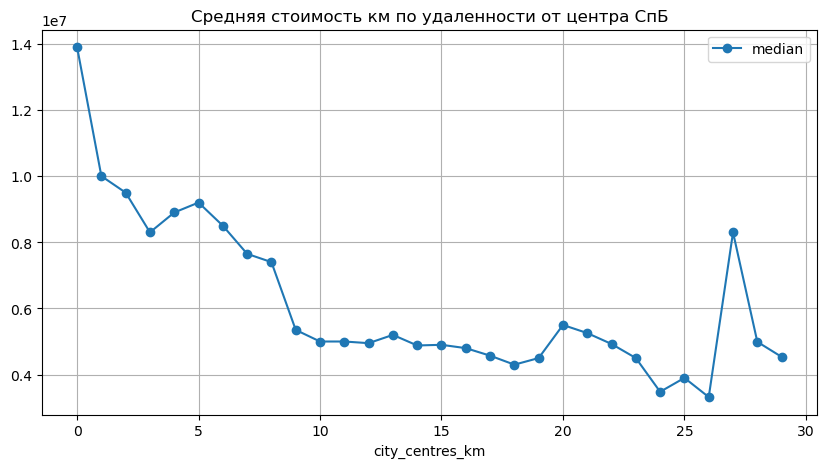

In [136]:
final_data = data_spb.pivot_table(index='city_centres_km', values='last_price', aggfunc={'median'}) # cоздаем сводную таблицу с помощью метода pivot_table
print(final_data.head(10)) # проверяем
final_data.plot(title='Средняя стоимость км по удаленности от центра СпБ', style='o-', grid=True, figsize=(10,5)); # строим график

На график явно виден рост цен за квадратный метр, начиная с 9 км, небольшой спад на 4 км (вероятно, это граница центрального района, общая площадь которого равна 17км2), и стремительный рост с 3км и до 0 (центральный район), где стоимость км равна более чем 10 млн.

In [137]:
data_27km = data_spb.query('city_centres_km == 27')
display(data_27km)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday,month,year,floor_type,city_centres_km,last_price_million
454,13,14350000.0,74.0,2017-11-28,2,3.13,5,30.0,3,False,...,0.0,NaN,128.0,193918,1,11,2017,другой,27.0,14.35
3837,6,2250000.0,32.0,2018-02-27,1,2.65,2,16.5,2,False,...,0.0,NaN,178.0,70312,1,2,2018,последний,27.0,2.25


In [138]:
data_27km['last_price'].describe()

count    2.000000e+00
mean     8.300000e+06
std      8.555992e+06
min      2.250000e+06
25%      5.275000e+06
50%      8.300000e+06
75%      1.132500e+07
max      1.435000e+07
Name: last_price, dtype: float64

Резкий скачок на 27км объяснется тем, что на данном удалении представлены всего 2 объекта сильно различающихся по стоимости, в связи с чем среднее значение рассчитывается некорректно. 

In [139]:
data_3km = data_spb.query('floor_type in ["первый", "последний", "другой"] and city_centres_km == 3')
data_3_filtered = (data_3km.groupby('floor_type')['city_centres_km'].agg(['count']).sort_values(by='count', ascending=False))
display(data_3_filtered)

,count
floor_type,
другой,195
последний,72
первый,49


In [140]:
data_5km = data_spb.query('floor_type in ["первый", "последний", "другой"] and city_centres_km == 5')
data_5_filtered = (data_5km.groupby('floor_type')['city_centres_km'].agg(['count']).sort_values(by='count', ascending=False))
display(data_5_filtered)

,count
floor_type,
другой,636
последний,126
первый,74


In [141]:
data_spb.floor_type.value_counts().to_frame()

,floor_type
другой,11843
последний,1793
первый,1543


Судя по таблицам, общее число объявлений в Санкт-Петербурге типам этажей имеет следующие параметры: из чем 15000 объявлений преобладающее большинство находятся на промежуточных этажах (11842 квартиры), в то время как на первый и последний этажи приходится по 1543 и 1793 объявлений соответственно. Таким образом общая доля объявлений на расстоянии 3км от центра составляет около 2%, а на расстоянии 5км - около 5,6%. 

В частности по удаленности 3 км доли по типам этажа следующие:
другой - 1,6%
последний - 4%
первый - 3%.

А по удаленности 5 км доли по типам этажа:
другой - 5,4%
последний - 7%
первый - 4,8%.
Таким образом, можно сделать вывод о том, провал цен на 3км может объясняться малым процентом наиболее распространенного в данных типа этажа - другой. Сравнение с данными по 5км, где процент в этой категории , как и в других выше, подтверждает вывод.

In [142]:
# check
data_spb.query('3 <= city_centres_km <= 5').groupby(['city_centres_km', 'rooms', 'floor_type'])['city_centres_km'].count()

city_centres_km  rooms  floor_type
3.0              1      другой         14
                        первый         11
                        последний       5
                 2      другой         59
                        первый         22
                        последний      21
                 3      другой         64
                        первый          9
                        последний      30
                 4      другой         35
                        первый          2
                        последний      11
                 5      другой         16
                        первый          4
                        последний       5
                 6      другой          7
                        первый          1
4.0              1      другой         63
                        первый         14
                        последний      12
                 2      другой        128
                        первый         25
                        последний      28

### Общий вывод

1) В таблице много пропущенный данных, частности в столбцах ceiling_height, living_area, locality, name, floors_total, is_apartment, kitchen_area, balcony, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest и days_exposition. Часть информации могла быть утеряна или испорчена в процессе выгрузки данных, другая могла быть не предоставлена пользователями. Данные были восстановлены на основе медианы в столбце ceiling_height. В других столбцах данные оставлены без изменений. При необходимости, данные, полученные картографически, можно запросить у соответствующих специалистов.

2) Данные приведены в соответствие со змеиным синтаксисом в столбце удаленности от центра.

3) Аномальные данные были исправлены, где это было возможно, в частности, опечатки в столбцах ceiling_height и last_price. Часть данных, не представляющих значимости для анализа (выбросов) или затрудниящих анализ (например, отсутствие названия местности), была удалена. Дубликаты также удалены. В общей сложности удалены 7% данным при допуститмом, но критичном значении в 10%.

4) Были внесены исправления в тип данных, в частности даты были преведены к типу данных datetime, графа апартаментов к булевому значению, а количество этажей и балконов - к целым числам (int).

5) В таблицу были добавлены доп. столбцы (средняя цена квадратного метра, год, месяц и день публикации, тип этажа, расстояние до центра в км).

6) Большинство данных, согласно графикам, в частности площадь, число комнат, высота потолков, расстояние до парка и др. напоминают распределение ПУассона, то есть не соответствуют нормальному. Наиболее близко к нормальному распределению данные по удаленности от центра города.

7) Медианное значение быстроты продажи соответствует 95 дням. Ниболее быстрыми можно считать продажи до 45 дней, а аномально долгими - более 500 дней. Большое количество выборосов в данном столбце может свдительствовать о том, что некоторые квартиры не пользуются спросом на рынке, а отсутствие данных по количеству дней размещения о том, что объявления еще не сняты с публикации. Наиболее долгие продажи наблюдаются в 2014, а наиболее быстрые - в 2019. В общем вырисовывается четкая тенденция по увеличению скорости продажи с 2014 по 2019 гг., наиболее резкий рост - с 2014 по 2016. 

8) Влияние отдельны параметров на стоимость объекта:
- наиболее значимый параметр, которые влияет на стоимость объекта - удалённость от центра;
- также на стоимость влияет общая площадь квартиры. Жилая площадь, площадь кухни и количество комнат имеют более низкие коэффициенты корреляции.
- наблюдается зависимость по количеству комнат - с повышением количества комнат увеличивается стоимость объекта. Это логично, так как при этом увеличивается общая площадь квартиры.
- нахождение объекта на определенном этаже не оказывает значимого влияния на цену, однако можно отметить, что наиболее низкую стоимость имеют объекты на первом этаже, за ними следуют объеты на последнем этаже и самыми дорогими являются объекты на других этажах.

9) Дата публикации(день, месяц и год) публикации не коррелируют со стоимостью объекта, однако при более детальном рассмотрении параметров было установлено, что средняя площадь и цены изменялись относительно равномерно: с 2014 по 2016 наблюдается резкий спад по обоим параметрам - с 75 до 53м2 и с 7,5 до 5,2 млн соответственно. С 2016 по 2018 ситуация несколько изменяется: средняя площадь постепенно уменьшается (с 53 до 50м2), а средняя цена остается примерно на том же уровне (4,5 млн), что говорит о некотором росте стоимости жилья в эти годы. С 2018 по 2019 по обоим параметрам виден рост, однако в отношении цены этот рост более значительный (с 4,5 до 5 млн) при увеличении средней площади жилья всего на 2 м2. По общему количеству объявлений с 2014 по 2016 виден стабильный рост с 0 до почти 3000 единиц, а с 2016 по 2017 происходит резкий скачок до 8000 объявлений и остается примерно на том же уровне до 2018. А в 2019 году наблюдается резкий спад до 3000 объявлений (уровень 2016г). Вероятно, это связано с тем, что при росте цен на недвижимость люди менее склонны к продаже, ожидая более выгодных для себя условий.

10) Согласно полученным данным наиболее высокую стоимость за м2 демонстрирует Спб (114749 руб.), а наиболее низкую - Поселок Дзержинского (33439 руб.)

11) Стоимость км по удаленности от центра имеет наиболее высокие показатели в пределах 3 км, что свидетельствует о том, что объекты, предположительно, находятся в центральном районе. Средняя стоимость км в этом диапазоне превышает 10 млн. руб. 
- некоторый рост цены на км наблюдается с 9 по 5 км, что свидетельсвует о востребованности объектов на таком удалении от центра. 
- небольшой спад цен за км от 5 до 3 вызван малым количеством данных, особенности на 3км по наиболее распространенному типу этажа объекта - не первому и не последнему. 
- резкий скачок на 27км объяснется тем, что на данном удалении представлены всего 2 объекта сильно различающихся по стоимости, в связи с чем среднее значение рассчитывается некорректно. 